<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/MiniProject_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project: SVM & Logistic Regression Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our group's Mini Project uses the same data that we explored during [Lab 1](https://nbviewer.jupyter.org/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4.ipynb), which you'll recall came from the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015 [Kaggle](https://www.kaggle.com/usdot/flight-delays). 

Our logistic regression and support vector machine models will focus on classifying flights using arrival delay as our response variable. As we noted in Lab 1's Business Understanding section, "Arrival delay serves as the total delay experienced by the flight and accounts for previous delays as well as time that pilots were able to make up in the air."

## 1. Logistic Regression & Support Vector Machine Models

> **[50 points]** Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.

### 1.1 Setup & Load Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. 
# Later on we will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Convert string columns to datetime
cols = ["WHEELS_OFF",  
        "WHEELS_ON"] 
df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

# Convert time to numeric for binning of the other times
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        "ARRIVAL_TIME"]
df[cols] = df[cols].apply(pd.to_numeric)

### 1.2 Create New Variables

The data contains several timestamp and continuous variables that add additional complexity. In order to simplify the data, we created buckets to analyze similar attributes together. 

We first convert `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, and `SCHEDULED_ARRIVAL` into buckets based on their timestamp. Because we are trying to predict arrivals we would not have access to the `ARRIVAL_TIME` data.

- **Overnight**: 12:00am - 4:00am
- **Morning**: 4:00am - 11:00am
- **Afternoon**: 11:00am - 4:00pm
- **Evening**: 4:00pm - 12:00am

[Flight] `DISTANCE` is also divided into buckets.

- **Short**: 1-99 miles
- **Medium**: 100-999 miles
- **Long**: 1,000+ miles

In [3]:
# Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 400, 1100, 1600, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'], 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'], 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'], 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Look at our data with the buckets
df.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_CODE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4           AS             98      N407AS   
1  2015      1    1            4           AA           2336      N3KUAA   
2  2015      1    1            4           US            840      N171US   
3  2015      1    1            4           AA            258      N3HYAA   
4  2015      1    1            4           AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  \
0            ANC                 SEA                    5  ...   
1            LAX                 PBI                   10  ...   
2            SFO                 CLT                   20  ...   
3            LAX                 MIA                   20  ...   
4            SEA                 ANC                   25  ...   

   AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY LATE_AIRCRAFT_DELAY  \
0               NaN             NaN            NaN                 NaN   
1               NaN             NaN            NaN                 NaN   
2               NaN             NaN            NaN                 NaN   
3               NaN             NaN            NaN                 NaN   
4               NaN             NaN            NaN                 NaN   

  WEATHER_DELAY                 AIRLINE  SCHED_DEPARTURE_TIME  \
0           NaN    Alaska Airlines Inc.             overnight   
1           NaN  American Airlines Inc.             overnight   
2           NaN         US Airways Inc.             overnight   
3           NaN  American Airlines Inc.             overnight   
4           NaN    Alaska Airlines Inc.             overnight   

   ACTUAL_DEPARTURE_TIME SCHED_ARRIVAL_TIME  DISTANCE_BUCKET  
0                evening            morning             Long  
1              overnight            morning             Long  
2              overnight            morning             Long  
3              overnight            morning             Long  
4              overnight          overnight             Long  

[5 rows x 36 columns]

In [4]:
# Check how many of each bin we have
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()
dist_bucket = df['DISTANCE_BUCKET'].value_counts()

print(sched_depart, '\n\n', actual_depart, '\n\n', sched_arrival, '\n\n', dist_bucket)

morning      2056248
evening      1971869
afternoon    1768922
overnight      22040
Name: SCHED_DEPARTURE_TIME, dtype: int64 

 evening      1999032
morning      1978882
afternoon    1716939
overnight      37560
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 

 evening      2676736
afternoon    1735865
morning      1317709
overnight      88767
Name: SCHED_ARRIVAL_TIME, dtype: int64 

 Medium    4102644
Long      1646627
Short       69808
Name: DISTANCE_BUCKET, dtype: int64


### 1.3 Missing Values

In [5]:
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

# Remove remaining null values
df = df.dropna()

### 1.4 Log Transformations

As we discovered during Lab 1, the `DEPARTURE_DELAY`, `ARRIVAL_DELAY`, `DISTANCE`, `TAXI_IN`, `ELAPSED_TIME`, and `AIR_TIME` variables are siginificantly right-skewed with a large number of outliers. In order to normalize these values, we did a log transformation.

In [6]:
# Log transformation keeping the 0 in the data sets 
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["ARRIVAL_DELAY_Log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["DISTANCE_log"]        = df["DISTANCE"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["TAXI_IN_Log"]         = df["TAXI_IN"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["ELAPSED_TIME_log"]    = df["ELAPSED_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["AIR_TIME_log"]        = df["AIR_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 

In [7]:
# These columns required log transformations to normalize the data therefore removed prior variable.
col_to_drop = ['DEPARTURE_DELAY','ARRIVAL_DELAY','DISTANCE','TAXI_IN',
               'ELAPSED_TIME', 'AIR_TIME']
df = df.drop(columns = col_to_drop)

In [8]:
# Check our current columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5717223 entries, 0 to 5819078
Data columns (total 36 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   YEAR                   int64   
 1   MONTH                  int64   
 2   DAY                    int64   
 3   DAY_OF_WEEK            int64   
 4   AIRLINE_CODE           object  
 5   FLIGHT_NUMBER          int64   
 6   TAIL_NUMBER            object  
 7   ORIGIN_AIRPORT         object  
 8   DESTINATION_AIRPORT    object  
 9   SCHEDULED_DEPARTURE    int64   
 10  DEPARTED               float64 
 11  TAXI_OUT               float64 
 12  WHEELS_OFF             object  
 13  SCHEDULED_TIME         object  
 14  WHEELS_ON              object  
 15  SCHEDULED_ARRIVAL      int64   
 16  ARRIVED                float64 
 17  DIVERTED               int64   
 18  CANCELLED              int64   
 19  CANCELLATION_REASON    object  
 20  AIR_SYSTEM_DELAY       float64 
 21  SECURITY_DELAY         float64 

In [9]:
# Look at the head of all columns
pd.set_option('display.max_columns', None)
df.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_CODE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4           AS             98      N407AS   
1  2015      1    1            4           AA           2336      N3KUAA   
2  2015      1    1            4           US            840      N171US   
3  2015      1    1            4           AA            258      N3HYAA   
4  2015      1    1            4           AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTED  TAXI_OUT  \
0            ANC                 SEA                    5       1.0      21.0   
1            LAX                 PBI                   10       1.0      12.0   
2            SFO                 CLT                   20       1.0      16.0   
3            LAX                 MIA                   20       1.0      15.0   
4            SEA                 ANC                   25       1.0      11.0   

  WHEELS_OFF SCHEDULED_TIME WHEELS_ON  SCHEDULED_ARRIVAL  ARRIVED  DIVERTED  \
0          1            205         1                430      1.0         0   
1          1            280         1                750      1.0         0   
2          1            286         1                806      1.0         0   
3          1            285         1                805      1.0         0   
4          1            235         1                320      1.0         0   

   CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  SECURITY_DELAY  \
0          0                   N               0.0             0.0   
1          0                   N               0.0             0.0   
2          0                   N               0.0             0.0   
3          0                   N               0.0             0.0   
4          0                   N               0.0             0.0   

   AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY                 AIRLINE  \
0            0.0                  0.0            0.0    Alaska Airlines Inc.   
1            0.0                  0.0            0.0  American Airlines Inc.   
2            0.0                  0.0            0.0         US Airways Inc.   
3            0.0                  0.0            0.0  American Airlines Inc.   
4            0.0                  0.0            0.0    Alaska Airlines Inc.   

  SCHED_DEPARTURE_TIME ACTUAL_DEPARTURE_TIME SCHED_ARRIVAL_TIME  \
0            overnight               evening            morning   
1            overnight             overnight            morning   
2            overnight             overnight            morning   
3            overnight             overnight            morning   
4            overnight             overnight          overnight   

  DISTANCE_BUCKET  DEPARTURE_DELAY_log  ARRIVAL_DELAY_Log  DISTANCE_log  \
0            Long                  0.0           0.000000      7.278629   
1            Long                  0.0           0.000000      7.754053   
2            Long                  0.0           1.791759      7.739359   
3            Long                  0.0           0.000000      7.759187   
4            Long                  0.0           0.000000      7.278629   

   TAXI_IN_Log  ELAPSED_TIME_log  AIR_TIME_log  
0     1.609438          5.273000      5.135798  
1     1.609438          5.634790      5.575949  
2     2.484907          5.683580      5.587249  
3     2.197225          5.641907      5.556828  
4     1.791759          5.375278      5.298317

In [10]:
# Convert scheduled time to be a numeric instead of an object.
df['SCHEDULED_TIME'] = pd.to_numeric(df['SCHEDULED_TIME'])

### 1.5 Remove Non-Cancelled Flights

Flights that are cancelled will, by their nature, not have an arrival delay. Therefore we remove those so that we are left with only the flights that were completed. 

In [11]:
df = df[df.CANCELLED == 0]

In [12]:
df.shape

(5713499, 36)

In [13]:
df.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_CODE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4           AS             98      N407AS   
1  2015      1    1            4           AA           2336      N3KUAA   
2  2015      1    1            4           US            840      N171US   
3  2015      1    1            4           AA            258      N3HYAA   
4  2015      1    1            4           AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTED  TAXI_OUT  \
0            ANC                 SEA                    5       1.0      21.0   
1            LAX                 PBI                   10       1.0      12.0   
2            SFO                 CLT                   20       1.0      16.0   
3            LAX                 MIA                   20       1.0      15.0   
4            SEA                 ANC                   25       1.0      11.0   

  WHEELS_OFF  SCHEDULED_TIME WHEELS_ON  SCHEDULED_ARRIVAL  ARRIVED  DIVERTED  \
0          1             205         1                430      1.0         0   
1          1             280         1                750      1.0         0   
2          1             286         1                806      1.0         0   
3          1             285         1                805      1.0         0   
4          1             235         1                320      1.0         0   

   CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  SECURITY_DELAY  \
0          0                   N               0.0             0.0   
1          0                   N               0.0             0.0   
2          0                   N               0.0             0.0   
3          0                   N               0.0             0.0   
4          0                   N               0.0             0.0   

   AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY                 AIRLINE  \
0            0.0                  0.0            0.0    Alaska Airlines Inc.   
1            0.0                  0.0            0.0  American Airlines Inc.   
2            0.0                  0.0            0.0         US Airways Inc.   
3            0.0                  0.0            0.0  American Airlines Inc.   
4            0.0                  0.0            0.0    Alaska Airlines Inc.   

  SCHED_DEPARTURE_TIME ACTUAL_DEPARTURE_TIME SCHED_ARRIVAL_TIME  \
0            overnight               evening            morning   
1            overnight             overnight            morning   
2            overnight             overnight            morning   
3            overnight             overnight            morning   
4            overnight             overnight          overnight   

  DISTANCE_BUCKET  DEPARTURE_DELAY_log  ARRIVAL_DELAY_Log  DISTANCE_log  \
0            Long                  0.0           0.000000      7.278629   
1            Long                  0.0           0.000000      7.754053   
2            Long                  0.0           1.791759      7.739359   
3            Long                  0.0           0.000000      7.759187   
4            Long                  0.0           0.000000      7.278629   

   TAXI_IN_Log  ELAPSED_TIME_log  AIR_TIME_log  
0     1.609438          5.273000      5.135798  
1     1.609438          5.634790      5.575949  
2     2.484907          5.683580      5.587249  
3     2.197225          5.641907      5.556828  
4     1.791759          5.375278      5.298317

### 1.6 Feature Removals

Here we remove redundant columns to further reduce the data size. Columns that are being removed:
- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have `AIRLINE_CODE` which is the same information
- `SCHEDULED_DEPARTURE` and `SCHEDULED_ARRIVAL`
- `CANCELLATION_REASON` and `CANCELLED`: We are looking at delays only so do not need cancellation details.
- `WHEELS_ON` and `WHEELS_OFF`: We made these binary instead of a time stamp, but this is no longer needed when we are looking at flights being delayed, as these values will all be `1`
- `DEPARTED` and `ARRIVED`: Again, these are binary values and are not needed as all will be equal to `1` after removing the cancelled flights

In [14]:
col_to_drop = ['YEAR','AIRLINE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
               'CANCELLED', 'CANCELLATION_REASON', 'WHEELS_ON', 'WHEELS_OFF', 
               'ARRIVED', 'DEPARTED']
df = df.drop(columns = col_to_drop)

In [15]:
df.head()

MONTH  DAY  DAY_OF_WEEK AIRLINE_CODE  FLIGHT_NUMBER TAIL_NUMBER  \
0      1    1            4           AS             98      N407AS   
1      1    1            4           AA           2336      N3KUAA   
2      1    1            4           US            840      N171US   
3      1    1            4           AA            258      N3HYAA   
4      1    1            4           AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  TAXI_OUT  SCHEDULED_TIME  DIVERTED  \
0            ANC                 SEA      21.0             205         0   
1            LAX                 PBI      12.0             280         0   
2            SFO                 CLT      16.0             286         0   
3            LAX                 MIA      15.0             285         0   
4            SEA                 ANC      11.0             235         0   

   AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
0               0.0             0.0            0.0                  0.0   
1               0.0             0.0            0.0                  0.0   
2               0.0             0.0            0.0                  0.0   
3               0.0             0.0            0.0                  0.0   
4               0.0             0.0            0.0                  0.0   

   WEATHER_DELAY SCHED_DEPARTURE_TIME ACTUAL_DEPARTURE_TIME  \
0            0.0            overnight               evening   
1            0.0            overnight             overnight   
2            0.0            overnight             overnight   
3            0.0            overnight             overnight   
4            0.0            overnight             overnight   

  SCHED_ARRIVAL_TIME DISTANCE_BUCKET  DEPARTURE_DELAY_log  ARRIVAL_DELAY_Log  \
0            morning            Long                  0.0           0.000000   
1            morning            Long                  0.0           0.000000   
2            morning            Long                  0.0           1.791759   
3            morning            Long                  0.0           0.000000   
4          overnight            Long                  0.0           0.000000   

   DISTANCE_log  TAXI_IN_Log  ELAPSED_TIME_log  AIR_TIME_log  
0      7.278629     1.609438          5.273000      5.135798  
1      7.754053     1.609438          5.634790      5.575949  
2      7.739359     2.484907          5.683580      5.587249  
3      7.759187     2.197225          5.641907      5.556828  
4      7.278629     1.791759          5.375278      5.298317

### 1.7 Encoding

We know that `TAIL_NUMBER`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT` contain a large number of unique values. Before proceeding, we wanted to check and see exactly how many of each we had.

In [16]:
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N121UA       1
N180UA       1
N7LEAA       1
N860NW       1
N7LBAA       1
Name: TAIL_NUMBER, Length: 4896, dtype: int64
ATL      343479
ORD      276544
DFW      232635
DEN      193345
LAX      191939
          ...  
11097         1
13459         1
11905         1
12265         1
14222         1
Name: ORIGIN_AIRPORT, Length: 929, dtype: int64
ATL      343052
ORD      275834
DFW      231744
DEN      193030
LAX      192128
          ...  
10666         1
15497         1
13459         1
14222         1
11097         1
Name: DESTINATION_AIRPORT, Length: 929, dtype: int64


We have 4,896 different airplanes (`TAIL_NUMBER`) and 929 different airports (`ORIGIN_AIRPORT` and `DESTINATION_AIRPORT`). If we one-hot encode all of these, it would create way too many columns. We would also run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers and 10 for the origin and destination airports so that we have a greater likelihood of including it within either the train or test set.

In [17]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
df = df[df.groupby('ORIGIN_AIRPORT').ORIGIN_AIRPORT.transform(len) > 9]
df = df[df.groupby('DESTINATION_AIRPORT').DESTINATION_AIRPORT.transform(len) > 9]
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N7LKAA       5
N119UA       5
N859NW       5
N74007       5
N78001       5
Name: TAIL_NUMBER, Length: 4844, dtype: int64
ATL      343459
ORD      276537
DFW      232632
DEN      193345
LAX      191919
          ...  
10208        10
11624        10
12003        10
11778        10
12819         8
Name: ORIGIN_AIRPORT, Length: 809, dtype: int64
ATL      343032
ORD      275825
DFW      231738
DEN      193030
LAX      192110
          ...  
11624        10
11778        10
16218        10
12003        10
11146        10
Name: DESTINATION_AIRPORT, Length: 808, dtype: int64


This now reduces to 4,844 unique tail numbers, 809 unique origin airports, and 808 unique destination airports. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4000+ columns on a 5 million row data set without moving to a cloud-based solution.

In [18]:
%%time

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['ORIGIN_AIRPORT_encode'] = labelencoder.fit_transform(df['ORIGIN_AIRPORT'].astype('str'))
df2 = df[['ORIGIN_AIRPORT','ORIGIN_AIRPORT_encode']]
df2 = df2.drop_duplicates(subset=['ORIGIN_AIRPORT'], keep='last')

df2.rename(columns={'ORIGIN_AIRPORT': 'DESTINATION_AIRPORT'}, inplace=True)
df2.rename(columns={'ORIGIN_AIRPORT_encode': 'DESTINATION_AIRPORT_encode'}, inplace=True)

df = pd.merge(df, df2, on='DESTINATION_AIRPORT', how = 'left')
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)

df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

# Drop original columns
col_to_drop = ['TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop)

CPU times: user 6.36 s, sys: 1.62 s, total: 7.98 s
Wall time: 8.12 s


For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly fewer.

In [19]:
%%time

categorical_columns = ['AIRLINE_CODE', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME',
                       'DISTANCE_BUCKET']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

df_OHE.head()

CPU times: user 8.31 s, sys: 3.01 s, total: 11.3 s
Wall time: 11.3 s


MONTH  DAY  DAY_OF_WEEK  FLIGHT_NUMBER  TAXI_OUT  SCHEDULED_TIME  DIVERTED  \
0      1    1            4             98      21.0             205         0   
1      1    1            4           2336      12.0             280         0   
2      1    1            4            840      16.0             286         0   
3      1    1            4            258      15.0             285         0   
4      1    1            4            135      11.0             235         0   

   AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
0               0.0             0.0            0.0                  0.0   
1               0.0             0.0            0.0                  0.0   
2               0.0             0.0            0.0                  0.0   
3               0.0             0.0            0.0                  0.0   
4               0.0             0.0            0.0                  0.0   

   WEATHER_DELAY  DEPARTURE_DELAY_log  ARRIVAL_DELAY_Log  DISTANCE_log  \
0            0.0                  0.0           0.000000      7.278629   
1            0.0                  0.0           0.000000      7.754053   
2            0.0                  0.0           1.791759      7.739359   
3            0.0                  0.0           0.000000      7.759187   
4            0.0                  0.0           0.000000      7.278629   

   TAXI_IN_Log  ELAPSED_TIME_log  AIR_TIME_log  ORIGIN_AIRPORT_encode  \
0     1.609438          5.273000      5.135798                    319   
1     1.609438          5.634790      5.575949                    478   
2     2.484907          5.683580      5.587249                    580   
3     2.197225          5.641907      5.556828                    478   
4     1.791759          5.375278      5.298317                    579   

   DESTINATION_AIRPORT_encode  TAIL_NUMBER_encode  AIRLINE_CODE_AA  \
0                       579.0                1610                0   
1                       537.0                1544                1   
2                       368.0                 415                0   
3                       505.0                1504                1   
4                       319.0                2119                0   

   AIRLINE_CODE_AS  AIRLINE_CODE_B6  AIRLINE_CODE_DL  AIRLINE_CODE_EV  \
0                1                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                1                0                0                0   

   AIRLINE_CODE_F9  AIRLINE_CODE_HA  AIRLINE_CODE_MQ  AIRLINE_CODE_NK  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   AIRLINE_CODE_OO  AIRLINE_CODE_UA  AIRLINE_CODE_US  AIRLINE_CODE_VX  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                1                0   
3                0                0                0                0   
4                0                0                0                0   

   AIRLINE_CODE_WN  SCHED_DEPARTURE_TIME_overnight  \
0                0                               1   
1                0                               1   
2                0                               1   
3                0                               1   
4                0                               1   

   SCHED_DEPARTURE_TIME_morning  SCHED_DEPARTURE_TIME_afternoon  \
0                             0                    

In [20]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 50 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   SCHEDULED_TIME                   int64  
 6   DIVERTED                         int64  
 7   AIR_SYSTEM_DELAY                 float64
 8   SECURITY_DELAY                   float64
 9   AIRLINE_DELAY                    float64
 10  LATE_AIRCRAFT_DELAY              float64
 11  WEATHER_DELAY                    float64
 12  DEPARTURE_DELAY_log              float64
 13  ARRIVAL_DELAY_Log                float64
 14  DISTANCE_log                     float64
 15  TAXI_IN_Log                      float64
 16  ELAPSED_TIME_log                 float64
 17  AIR_TIME

### 1.8 Create Response Variable

In [21]:
# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df_OHE['DELAYED'] = df_OHE.ARRIVAL_DELAY_Log.apply(get_delay)
df_OHE = df_OHE.drop(columns = 'ARRIVAL_DELAY_Log')
df_OHE.head()

MONTH  DAY  DAY_OF_WEEK  FLIGHT_NUMBER  TAXI_OUT  SCHEDULED_TIME  DIVERTED  \
0      1    1            4             98      21.0             205         0   
1      1    1            4           2336      12.0             280         0   
2      1    1            4            840      16.0             286         0   
3      1    1            4            258      15.0             285         0   
4      1    1            4            135      11.0             235         0   

   AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
0               0.0             0.0            0.0                  0.0   
1               0.0             0.0            0.0                  0.0   
2               0.0             0.0            0.0                  0.0   
3               0.0             0.0            0.0                  0.0   
4               0.0             0.0            0.0                  0.0   

   WEATHER_DELAY  DEPARTURE_DELAY_log  DISTANCE_log  TAXI_IN_Log  \
0            0.0                  0.0      7.278629     1.609438   
1            0.0                  0.0      7.754053     1.609438   
2            0.0                  0.0      7.739359     2.484907   
3            0.0                  0.0      7.759187     2.197225   
4            0.0                  0.0      7.278629     1.791759   

   ELAPSED_TIME_log  AIR_TIME_log  ORIGIN_AIRPORT_encode  \
0          5.273000      5.135798                    319   
1          5.634790      5.575949                    478   
2          5.683580      5.587249                    580   
3          5.641907      5.556828                    478   
4          5.375278      5.298317                    579   

   DESTINATION_AIRPORT_encode  TAIL_NUMBER_encode  AIRLINE_CODE_AA  \
0                       579.0                1610                0   
1                       537.0                1544                1   
2                       368.0                 415                0   
3                       505.0                1504                1   
4                       319.0                2119                0   

   AIRLINE_CODE_AS  AIRLINE_CODE_B6  AIRLINE_CODE_DL  AIRLINE_CODE_EV  \
0                1                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                1                0                0                0   

   AIRLINE_CODE_F9  AIRLINE_CODE_HA  AIRLINE_CODE_MQ  AIRLINE_CODE_NK  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   AIRLINE_CODE_OO  AIRLINE_CODE_UA  AIRLINE_CODE_US  AIRLINE_CODE_VX  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                1                0   
3                0                0                0                0   
4                0                0                0                0   

   AIRLINE_CODE_WN  SCHED_DEPARTURE_TIME_overnight  \
0                0                               1   
1                0                               1   
2                0                               1   
3                0                               1   
4                0                               1   

   SCHED_DEPARTURE_TIME_morning  SCHED_DEPARTURE_TIME_afternoon  \
0                             0                               0   
1                             0                               0   
2                             0

In [22]:
# Check the response variable distribution
df_OHE['DELAYED'].value_counts()

0    3626052
1    2086178
Name: DELAYED, dtype: int64

### 1.9 Check Correlations

<AxesSubplot:>

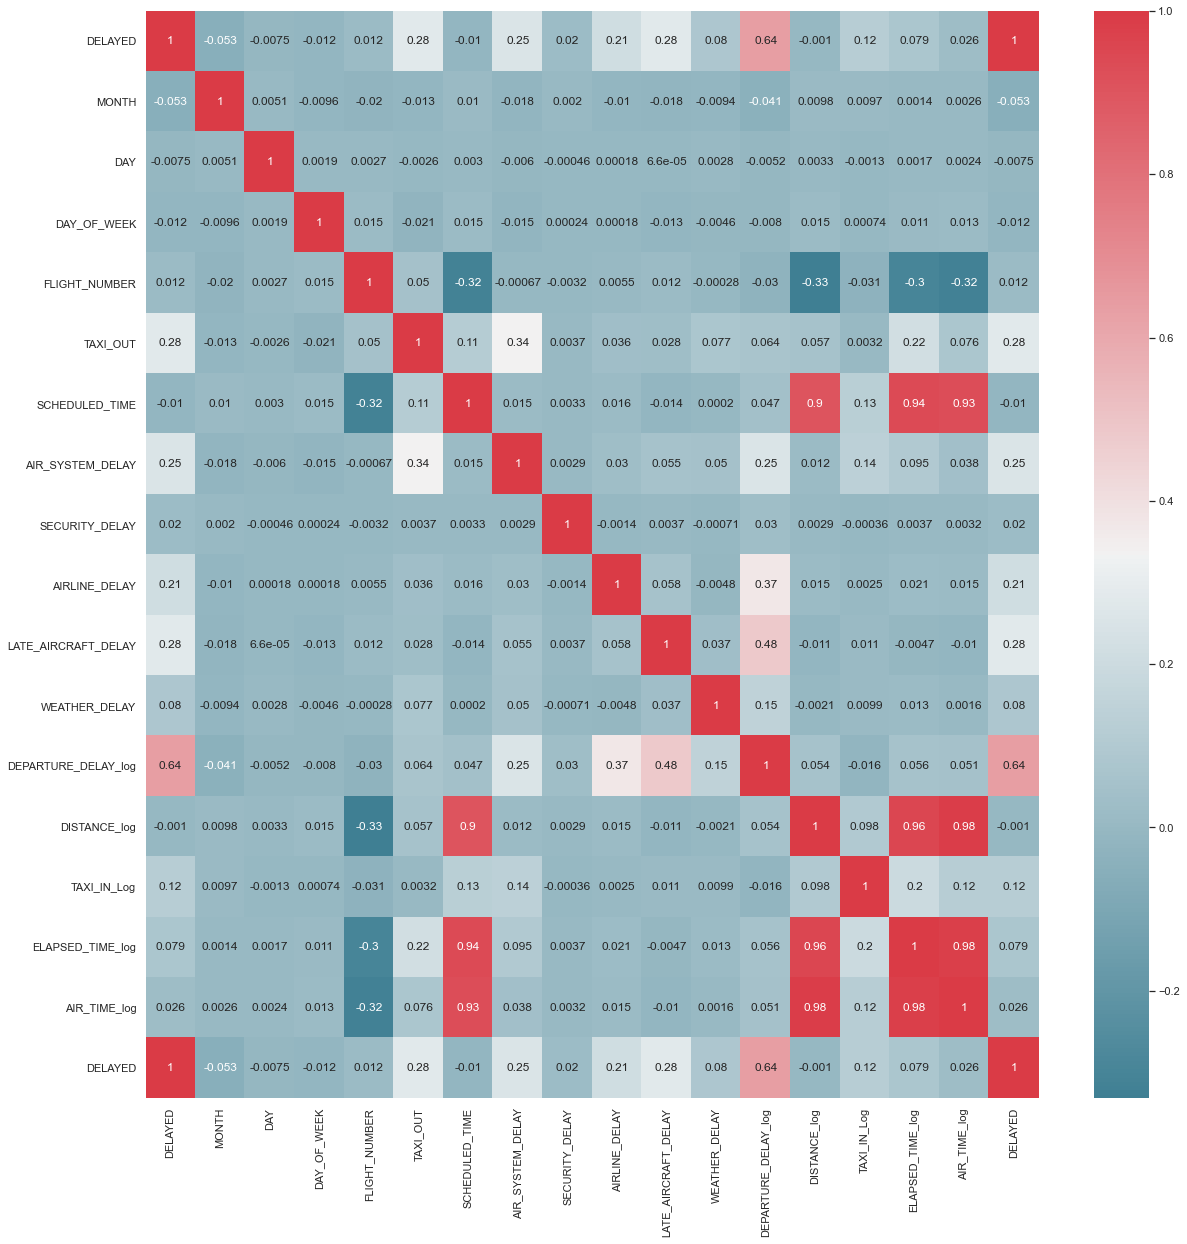

In [23]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for response and continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'TAXI_OUT','SCHEDULED_TIME',
           'AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'DEPARTURE_DELAY_log',
          'DISTANCE_log', 'TAXI_IN_Log','ELAPSED_TIME_log',
          'AIR_TIME_log','DELAYED']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

`SCHEDULED_TIME`, `ELAPSED_TIME_log`, `AIR_TIME_log`, `DISTANCE_log` are all highly correlated. For the purposes here we want to only keep `DISTANCE_log`, the decision to keep this variable was that we would not know the Air Time and Elapsed Time since we are trying to predict if the plane would be delayed prior to flight and distance would always be known. 

In [24]:
# Drop SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, and their log versions as well as DEPARTURE_DELAY
col_to_drop2 = ['SCHEDULED_TIME', 'ELAPSED_TIME_log', 'AIR_TIME_log']
df_OHE = df_OHE.drop(columns = col_to_drop2)

<AxesSubplot:>

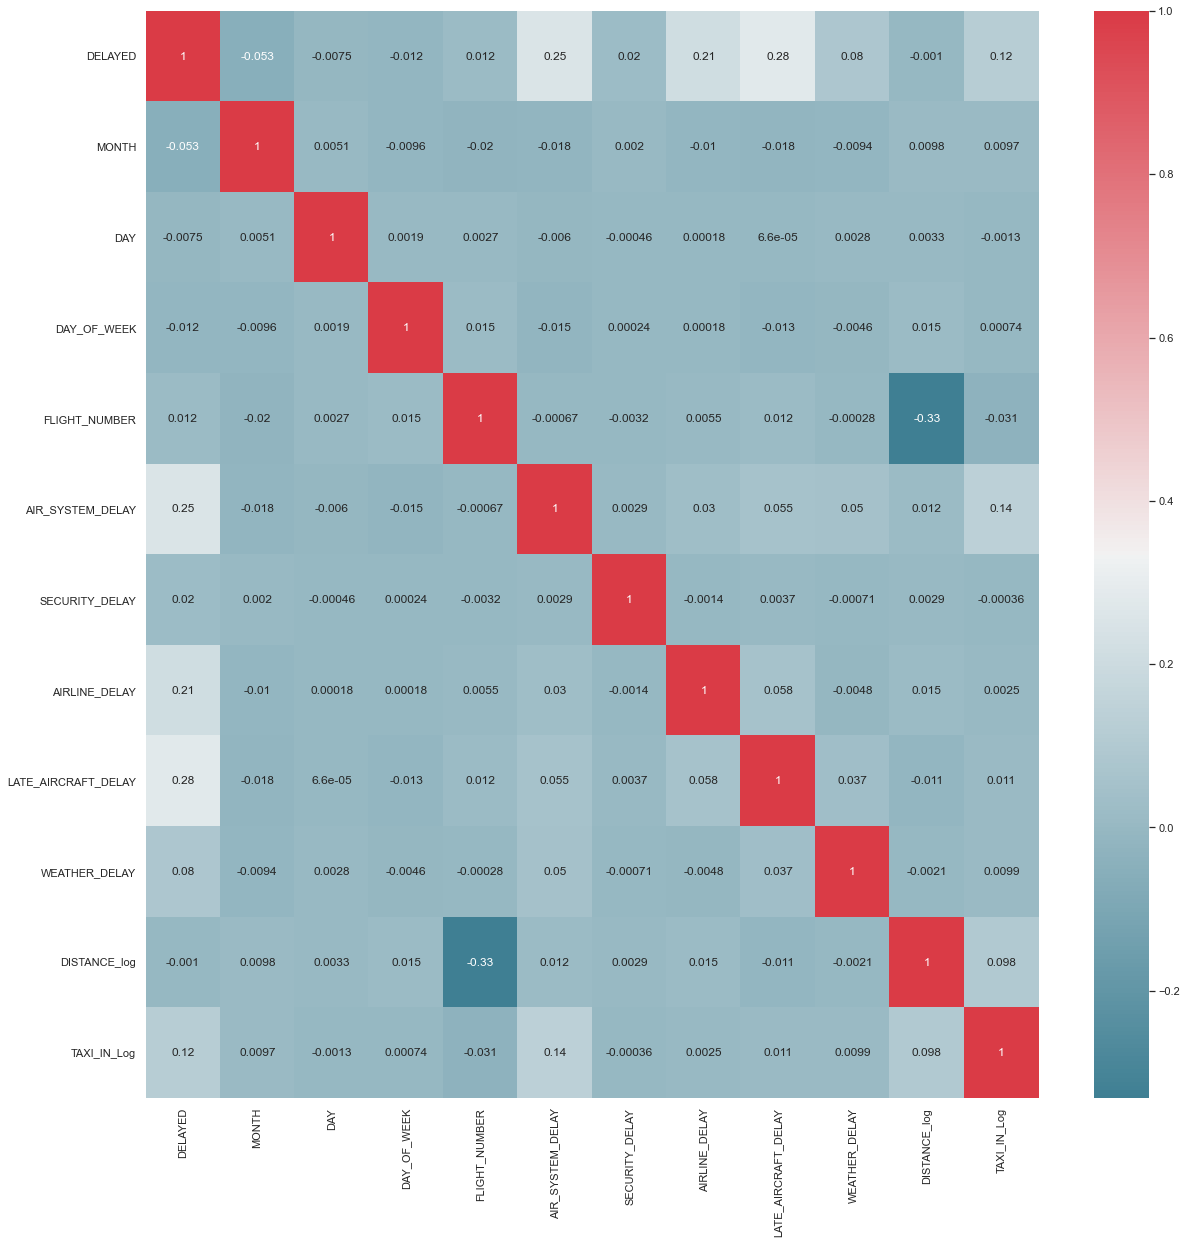

In [25]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for the remaining continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY',
         'DISTANCE_log', 'TAXI_IN_Log']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

In [26]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 47 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   DIVERTED                         int64  
 6   AIR_SYSTEM_DELAY                 float64
 7   SECURITY_DELAY                   float64
 8   AIRLINE_DELAY                    float64
 9   LATE_AIRCRAFT_DELAY              float64
 10  WEATHER_DELAY                    float64
 11  DEPARTURE_DELAY_log              float64
 12  DISTANCE_log                     float64
 13  TAXI_IN_Log                      float64
 14  ORIGIN_AIRPORT_encode            int64  
 15  DESTINATION_AIRPORT_encode       float64
 16  TAIL_NUMBER_encode               int64  
 17  AIRLINE_

In [27]:
# Get the location of the `DELAYED` column for use in VIF below
df_OHE.columns.get_loc('DELAYED')

46

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
X = df_OHE.iloc[:, 0:45]
X['Intercept'] = 1
  
# calculating VIF for each feature
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  
print(vif)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                          variables       VIF
0                             MONTH  1.107417
1                               DAY  1.000217
2                       DAY_OF_WEEK  1.003048
3                     FLIGHT_NUMBER  3.576430
4                          TAXI_OUT  1.255616
5                          DIVERTED       NaN
6                  AIR_SYSTEM_DELAY  1.281466
7                    SECURITY_DELAY  1.001717
8                     AIRLINE_DELAY  1.253206
9               LATE_AIRCRAFT_DELAY  1.417720
10                    WEATHER_DELAY  1.041128
11              DEPARTURE_DELAY_log  1.862277
12                     DISTANCE_log  2.734744
13                      TAXI_IN_Log  1.116214
14            ORIGIN_AIRPORT_encode  1.405710
15       DESTINATION_AIRPORT_encode  1.415366
16               TAIL_NUMBER_encode  1.151381
17                  AIRLINE_CODE_AA       inf
18                  AIRLINE_CODE_AS       inf
19                  AIRLINE_CODE_B6       inf
20                  AIRLINE_CODE_D

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


The `AIRLINE_CODE_`, `SCHED_DEPARTURE_TIME_`, `ACTUAL_DEPARTURE_TIME_`, and `SCHED_ARRIVAL_TIME_` one-hot encodings are returning perfect multicollinearity so we'll remove one of each and re-run the VIF. After thinking this through, it makes sense that the actual departure and arrival times are a dead giveaway for delays. Same with our other delay types (`AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, `WEATHER_DELAY`, and ARRIVAL_DELAY buckets). Logically, the airline code and the scheduled times shouldn't impact our VIF, so let's remove the delay types as well.

In [29]:
features = df_OHE.iloc[:,:12]
features

MONTH  DAY  DAY_OF_WEEK  FLIGHT_NUMBER  TAXI_OUT  DIVERTED  \
0            1    1            4             98      21.0         0   
1            1    1            4           2336      12.0         0   
2            1    1            4            840      16.0         0   
3            1    1            4            258      15.0         0   
4            1    1            4            135      11.0         0   
...        ...  ...          ...            ...       ...       ...   
5712235     12   31            4            688      22.0         0   
5712236     12   31            4            745      17.0         0   
5712237     12   31            4           1503      17.0         0   
5712238     12   31            4            333      10.0         0   
5712239     12   31            4            839      14.0         0   

         AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
0                     0.0             0.0            0.0                  0.0   
1                     0.0             0.0            0.0                  0.0   
2                     0.0             0.0            0.0                  0.0   
3                     0.0             0.0            0.0                  0.0   
4                     0.0             0.0            0.0                  0.0   
...                   ...             ...            ...                  ...   
5712235               0.0             0.0            0.0                  0.0   
5712236               0.0             0.0            0.0                  0.0   
5712237               0.0             0.0            0.0                  0.0   
5712238               0.0             0.0            0.0                  0.0   
5712239               0.0             0.0            0.0                  0.0   

         WEATHER_DELAY  DEPARTURE_DELAY_log  
0                  0.0             0.000000  
1                  0.0             0.000000  
2                  0.0             0.000000  
3                  0.0             0.000000  
4                  0.0             0.000000  
...                ...                  ...  
5712235            0.0             0.000000  
5712236            0.0             0.000000  
5712237            0.0             0.000000  
5712238            0.0             0.000000  
5712239            0.0             2.772589  

[5712230 rows x 12 columns]

In [30]:
# Drop the remaining highly correlated variables DISTANCE, TAXI_IN, ARRIVAL_DELAY, and ARRIVAL_DELAY_Log
col_to_drop4 = ['ACTUAL_DEPARTURE_TIME_morning', 'ACTUAL_DEPARTURE_TIME_afternoon', 'ACTUAL_DEPARTURE_TIME_evening', 'ACTUAL_DEPARTURE_TIME_overnight', 
                 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df_OHE = df_OHE.drop(columns = col_to_drop4)

In [31]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DEPARTURE_DELAY_log             float64
 7   DISTANCE_log                    float64
 8   TAXI_IN_Log                     float64
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

### 1.10 Test/Train Split

Our desired variable for classication will be our binary value for delay to determine whether or not a flight was delayed on arrival.

In [32]:
# Prep for the split by moving the response variable to the last column.
cols = list(df_OHE.columns.values) 
cols.pop(cols.index('DELAYED')) 
df_final = df_OHE[cols+['DELAYED']]

In [33]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DEPARTURE_DELAY_log             float64
 7   DISTANCE_log                    float64
 8   TAXI_IN_Log                     float64
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

In [70]:
from sklearn.model_selection import ShuffleSplit

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    # del df_final['DELAYED'] # get rid of the class label
    X = df_final.iloc[:,:-1].values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
# To use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits.
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)


In [35]:
X.shape

(5712230, 37)

In [36]:
y.shape

(5712230,)

In [37]:
features = list(df_final.iloc[:,:-1])
features

['MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'FLIGHT_NUMBER',
 'TAXI_OUT',
 'DIVERTED',
 'DEPARTURE_DELAY_log',
 'DISTANCE_log',
 'TAXI_IN_Log',
 'ORIGIN_AIRPORT_encode',
 'DESTINATION_AIRPORT_encode',
 'TAIL_NUMBER_encode',
 'AIRLINE_CODE_AA',
 'AIRLINE_CODE_AS',
 'AIRLINE_CODE_B6',
 'AIRLINE_CODE_DL',
 'AIRLINE_CODE_EV',
 'AIRLINE_CODE_F9',
 'AIRLINE_CODE_HA',
 'AIRLINE_CODE_MQ',
 'AIRLINE_CODE_NK',
 'AIRLINE_CODE_OO',
 'AIRLINE_CODE_UA',
 'AIRLINE_CODE_US',
 'AIRLINE_CODE_VX',
 'AIRLINE_CODE_WN',
 'SCHED_DEPARTURE_TIME_overnight',
 'SCHED_DEPARTURE_TIME_morning',
 'SCHED_DEPARTURE_TIME_afternoon',
 'SCHED_DEPARTURE_TIME_evening',
 'SCHED_ARRIVAL_TIME_overnight',
 'SCHED_ARRIVAL_TIME_morning',
 'SCHED_ARRIVAL_TIME_afternoon',
 'SCHED_ARRIVAL_TIME_evening',
 'DISTANCE_BUCKET_Short',
 'DISTANCE_BUCKET_Medium',
 'DISTANCE_BUCKET_Long']

### 1.11 Lasso Regression

In [71]:
# Alternate test/train split for use in lasso regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [72]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

grid = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)}, #test values of alpha from 0.1 to 10
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [40]:
# # Run grid search
# grid.fit(X_train,y_train)

In [41]:
# # Find the best value of alpha
# grid.best_params_

In [42]:
# # Find coefficients
# coefficients = grid.best_estimator_.named_steps['model'].coef_
# coefficients

In [43]:
# # Find the most important features
# np.array(features)[coefficients > 0]

The above code is commented out due to the length of time LASSO regression takes to run. Based on previous runs, the only important features in our data set are TAXI-OUT and DEPARTURE_DELAY_log. This is possibly an indicator that our data set for predicting DELAY may not be the best. We do not want to remove all other variables at this point, but this is an interesting finding to keep in mind for the remainder of our analysis. Let's run PCA next to see if it shows any promise for dimension reduction.

### 1.12 PCA

In [44]:
# Standardize the features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create the object
scaler = StandardScaler()

# Calculate the mean and standard deviation
scaler.fit(df_final.iloc[:,:-1]) #scale everything except response variable
df_pca_scaled = scaler.transform(df_final.iloc[:,:-1])

# Calculate the PCA that explains 95% of the variance
pca_95 = PCA(n_components=0.95, random_state=2015)
pca_95.fit(df_pca_scaled)
df_pca_95 = pca_95.transform(df_pca_scaled)

# Display the PCA values
np.cumsum(pca_95.explained_variance_ratio_*100)

array([ 8.98904972, 16.87338567, 22.50483458, 27.4868927 , 32.04993396,
       36.02697391, 39.92814594, 43.61029312, 46.91890225, 50.09240714,
       53.23293702, 56.2378112 , 59.23256819, 62.14765254, 65.02618407,
       67.8643804 , 70.67806787, 73.45446262, 76.22395773, 78.98324411,
       81.65217484, 84.24192365, 86.5800357 , 88.72800751, 90.8254909 ,
       92.88294714, 94.87316269, 96.7127538 ])

In this version of our data set, it takes 28 principal components to get up to 95% explained variability.

Text(0, 0.5, 'Explained Variance')

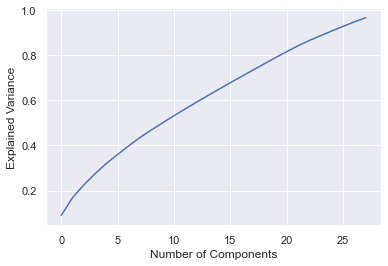

In [45]:
# Plot PCA results
plt.plot(np.cumsum(pca_95.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [46]:
df_post_pca = pd.DataFrame(df_pca_95, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
                                                 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15',
                                                 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22',
                                                 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28'])
df_post_pca['Delayed'] = df_final.DELAYED
df_post_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.609769 -2.443451 -1.695949 -1.639898  0.055845 -0.161267  0.911516   
1  3.455453 -2.458344 -1.456305 -1.672021  1.271297 -0.760421  0.140543   
2  3.616934 -2.549772 -1.623507 -2.081723  0.806378  0.000110 -0.070049   
3  3.935454 -2.600275 -1.532814 -1.229612  1.237222 -0.794676  0.248912   
4  4.317083 -1.234068 -1.176625 -1.528833 -0.504365 -0.426565  0.813690   

        PC8       PC9      PC10      PC11      PC12       PC13      PC14  \
0  0.666445  0.546937 -2.040368 -4.224530  2.959413   9.284651  2.101439   
1  0.258987 -1.226247 -1.962383 -3.228313  5.264796   5.705031  1.949376   
2  2.431868  0.290205  0.077004 -4.366121  7.786380   4.918931  2.286673   
3  1.024572 -1.654687 -1.759163 -3.116145  5.281418   5.637600  1.982772   
4 -0.862122  1.022784 -1.347724 -1.196321  4.042615  11.224396  5.873542   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0  5.238942  0.799259 -3.781516 -1.690615  2.467831  6.107657  7.565242   
1  6.108941 -0.439638 -2.550432 -1.268272  0.160887  7.107252  8.629368   
2  4.897154  0.123388 -4.131614 -1.379360  2.673682  6.534059  7.890720   
3  6.051377 -0.364234 -2.433270 -1.254712  0.173828  6.933079  8.563683   
4  0.779014  0.002959 -2.593895 -1.914241  2.277828  7.380133  8.557572   

       PC22      PC23      PC24      PC25      PC26      PC27      PC28  \
0  1.882498  0.373663 -3.377413 -0.139191  0.000205  2.853126  0.035745   
1 -0.163975 -1.265021 -3.384477 -0.479260  0.658617  1.485193 -0.311974   
2 -0.866192  0.022693 -2.927653  2.527630  0.346128  1.344184  1.046194   
3 -0.391714 -0.569587 -3.462834 -0.141799  0.800028  2.112781 -0.272909   
4 -0.625707  2.000488 -2.327584 -0.577008 -0.154607  2.840544 -0.186741   

   Delayed  
0      0.0  
1      0.0  
2      1.0  
3      0.0  
4      0.0

Text(0, 0.5, 'Second Principal Component')

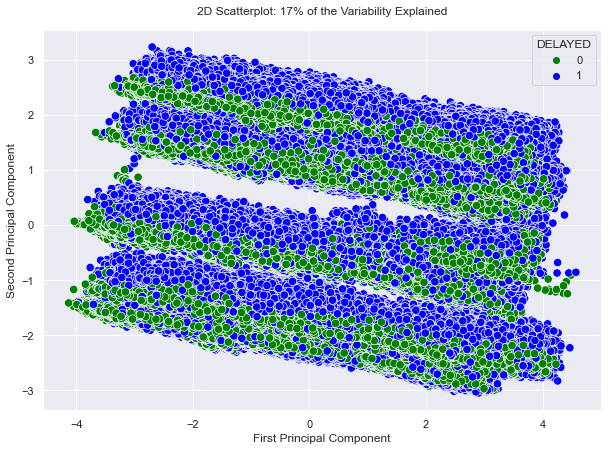

In [47]:
# Plot first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca_95[:, 0], y=df_pca_95[:, 1], s=70,
               hue=df_final.DELAYED, palette=['green', 'blue'])

plt.title("2D Scatterplot: 17% of the Variability Explained", pad=15)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

This is an interesting plot, but we don't see clear separation for our desired response variable. Therefore, PCA is not useful for dimension reduction on this data set.

### 1.13 Logistic Regression

First, we will run a fairly standard logistic regression model with 3-fold cross validation. For initial parameters, we will start with an L2 penalty, cost of 1.0, and the `LogisticRegression` classifier from sklearn. We will run three iterations of a test/train split and output the confusion matrix for each.

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Define our model
lr_clf = LogisticRegression(penalty='l2', 
                            C=1.0, 
                            class_weight=None,
                            solver='liblinear')

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8567582187692022
confusion matrix
 [[667215  58317]
 [105329 311585]]
====Iteration 1  ====
accuracy 0.8542486909665752
confusion matrix
 [[665588  59226]
 [107287 310345]]
====Iteration 2  ====
accuracy 0.8539204478811252
confusion matrix
 [[665339  59523]
 [107365 310219]]


Overall, this is actually very good performance for a first-pass "out of the box" type model with little configuration. Across three separate iterations, our accuracy was very consistent and hovered around 85% for each run. A quick glance at the confusion matrix also looks pretty decent given our test sample size. Just looking at our last iteration, we had a false positive rate of 13.9% and a false negative rate of 16.1%.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#define pipeline
#pipeline = Pipeline([
#                     ('scaler',StandardScaler()),
#                     ('model',LogisticRegression())
#])

#param_grid = [{'model__C': [1, 10, 100], 
#               'model__solver': ['sag', 'saga','liblinear'], 
#               'model__penalty' : ['l1', 'l2']}]

#grid = GridSearchCV(pipeline,
#                    param_grid,
#                    cv=3,
#                    n_jobs=-1,
#                    verbose=2,
#                    scoring="accuracy")

#run grid search
#grid.fit(X_train,y_train)

At this point, we attempted to run a grid search varying `C`, `solver`, and `penalty`, but due to the data size and memory limitations, it crashed every time. Therefore, the remainder of the logistic regression iterations are done with individual variations of parameters and classifier types.

The code below is adapted from class notebook `04. Logits and SVM.ipynb`. Run logistic regression again, this time with 5 iterations but using the `SGDClassifier` (stochastic gradient descent) with log loss setting instead of `LogisticRegression` since we have such a large data set.

In [50]:
# Create new CV object for our split
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit(n_splits=1,test_size=0.2)

In [51]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

regularize_const = 0.1
iterations = 5

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)
print('Confusion Matrix:\n', conf)

Logistic Regression: 0.8465844337500416
Confusion Matrix:
 [[695214  29996]
 [145273 271963]]
CPU times: user 22.2 s, sys: 1.71 s, total: 23.9 s
Wall time: 22.4 s


The accuracy decreased slightly during this run to 84.6%, but not a very large change. Next we will change the alpha value to see if that will change our accuracy.

In [52]:
# Re-run with new regularize value of 0.01

regularize_const = 0.01

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)
print('Confusion Matrix:\n', conf)

Logistic Regression: 0.8556850827085044
Confusion Matrix:
 [[673244  51966]
 [112906 304330]]


This improved accuracy to 85.6%, but still no big improvement.

In [53]:
#re-run with new regularize value

regularize_const = 0.001

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)
print('Confusion Matrix:\n', conf)

Logistic Regression: 0.8567582187692022
Confusion Matrix:
 [[667308  57902]
 [105744 311492]]


Again, not much improvement. Let's change penalty type to see if that changes accuracy.

In [54]:
#re-run with l1 penalty

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l1',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)
print('Confusion Matrix:\n', conf)

Logistic Regression: 0.856478993317846
Confusion Matrix:
 [[666477  58733]
 [105232 312004]]


No big changes here either. Let's proceed with the best accuracy so far, but run with 10-fold cross-validation.

In [55]:
#test use 10-fold cv object
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=10, test_size=0.2, train_size=None)


In [56]:
%%time

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)
print('Confusion Matrix:\n', conf)

Logistic Regression: 0.8564833698923188
Confusion Matrix:
 [[668029  57447]
 [106513 310457]]
CPU times: user 3min 26s, sys: 15.3 s, total: 3min 41s
Wall time: 3min 27s


In [57]:
# Iterate over the coefficients and interpret the weights
weights = log_sgd.coef_.T # take transpose to make a column vector
variable_names = df_final.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.09496369151209108
DAY has weight of -0.012073685406575508
DAY_OF_WEEK has weight of -0.018779815254116896
FLIGHT_NUMBER has weight of -0.009437064249889889
TAXI_OUT has weight of 1.3419530883615494
DIVERTED has weight of 0.0
DEPARTURE_DELAY_log has weight of 2.1681563563268185
DISTANCE_log has weight of -0.2098783016469856
TAXI_IN_Log has weight of 0.6730786555740075
ORIGIN_AIRPORT_encode has weight of 0.023512479849286772
DESTINATION_AIRPORT_encode has weight of 0.04384597047179894
TAIL_NUMBER_encode has weight of -0.026184299414015618
AIRLINE_CODE_AA has weight of -0.10346468214568627
AIRLINE_CODE_AS has weight of 0.13028817093365003
AIRLINE_CODE_B6 has weight of 0.015447974870684686
AIRLINE_CODE_DL has weight of -0.20531560633429166
AIRLINE_CODE_EV has weight of 0.050339895304018493
AIRLINE_CODE_F9 has weight of 0.06476609034047764
AIRLINE_CODE_HA has weight of 0.16967475098039153
AIRLINE_CODE_MQ has weight of -0.04518247357334646
AIRLINE_CODE_NK has weight of

In [58]:
df_weights = df_final.iloc[:,:-1]

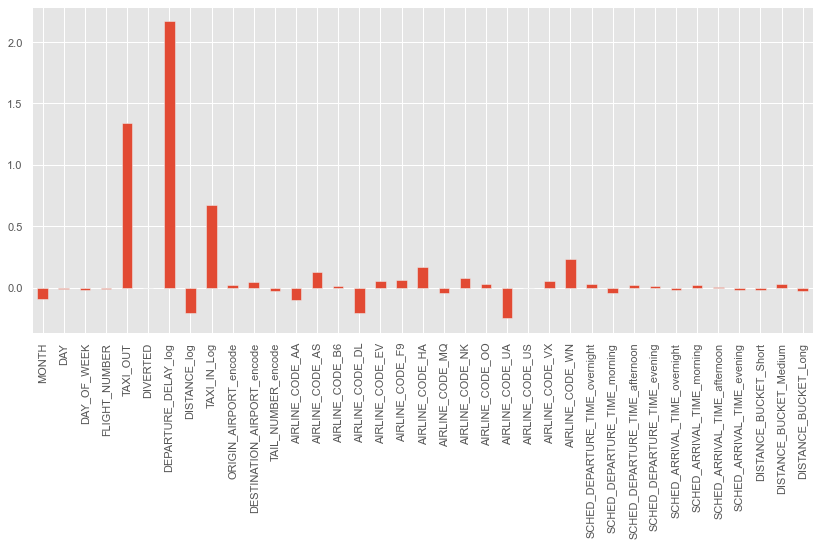

In [59]:
# Now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(14,6))

weights = pd.Series(log_sgd.coef_[0],index=df_weights.columns)
weights.plot(kind='bar')
plt.show()

`TAXI_OUT`, `DEPARTURE_DELAY_log`, and `TAXI_IN_Log` all have very high coefficients. `DIVERTED` has a coefficient of 0 in this model. Let's test re-running logistic regression and feature importance after removing those four variables.

In [60]:
# Remove these variables and create new test/train split
vars_SUB = ['MONTH',
            'DAY',
            'DAY_OF_WEEK',
            'FLIGHT_NUMBER',
            'DISTANCE_log',
            'ORIGIN_AIRPORT_encode',
            'DESTINATION_AIRPORT_encode',
            'TAIL_NUMBER_encode',
            'AIRLINE_CODE_AA',
            'AIRLINE_CODE_AS',
            'AIRLINE_CODE_B6' ,
            'AIRLINE_CODE_DL',
            'AIRLINE_CODE_EV',
            'AIRLINE_CODE_F9',
            'AIRLINE_CODE_HA',
            'AIRLINE_CODE_MQ',
            'AIRLINE_CODE_NK',
            'AIRLINE_CODE_OO',
            'AIRLINE_CODE_UA',
            'AIRLINE_CODE_US' , 
            'AIRLINE_CODE_VX',
            'AIRLINE_CODE_WN',
            'SCHED_DEPARTURE_TIME_overnight',
            'SCHED_DEPARTURE_TIME_morning',
            'SCHED_DEPARTURE_TIME_afternoon',
            'SCHED_DEPARTURE_TIME_evening',
            'SCHED_ARRIVAL_TIME_overnight',
            'SCHED_ARRIVAL_TIME_morning',
            'SCHED_ARRIVAL_TIME_afternoon',
            'SCHED_ARRIVAL_TIME_evening',
            'DISTANCE_BUCKET_Short',
            'DISTANCE_BUCKET_Medium',
            'DISTANCE_BUCKET_Long'
           ]

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y_sub = df_final['DELAYED'].values # get the labels we want
    X_sub = df_final[vars_SUB].values # use everything else to predict!

In [61]:
X_sub.shape

(5712230, 33)

In [63]:
%%time
num_cv_iterations = 3
num_instances = len(y_sub)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

regularize_const = 0.1
iterations = 5

log_sgd_sub = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X_sub,y_sub):
    log_sgd_sub.fit(scl.fit_transform(X_sub[train_idx]),y_sub[train_idx])
    yhat = log_sgd_sub.predict(scl.transform(X_sub[test_idx]))
    
    conf_sub = mt.confusion_matrix(y_sub[test_idx],yhat)
    acc_sub = mt.accuracy_score(y_sub[test_idx],yhat)

print('Logistic Regression:', acc_sub)
print('Confusion Matrix:\n', conf_sub)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)
Logistic Regression: 0.6357342053803856
Confusion Matrix:
 [[720381   4481]
 [411673   5911]]
CPU times: user 54.3 s, sys: 3.9 s, total: 58.2 s
Wall time: 53.8 s


When we remove the top three highest-weighted variables and `DIVERTED`, which had a weight of `0`, our accuracy decreases from 85% to 63%. We would expect our accuracy to decrease after removing these variables, as our initial model placed higher importance on them. However, even though it does decrease the accuracy, it's still a somewhat decent model at 63%. Next, we will compare the variable weights without these to see if we see any significant changes.

In [64]:
# Iterate over the coefficients and interpret the weights
weights_sub = log_sgd_sub.coef_.T # take transpose to make a column vector
variable_names = df_final[vars_SUB]
for coef, name in zip(weights_sub,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.06739066957110228
DAY has weight of -0.010359954435967296
DAY_OF_WEEK has weight of -0.01970793995808001
FLIGHT_NUMBER has weight of 0.009751378490926268
DISTANCE_log has weight of 0.0016578105552243103
ORIGIN_AIRPORT_encode has weight of 0.025615302165053647
DESTINATION_AIRPORT_encode has weight of 0.03670215343210099
TAIL_NUMBER_encode has weight of -0.015436826332782762
AIRLINE_CODE_AA has weight of -0.007893472329668545
AIRLINE_CODE_AS has weight of -0.02011293789837286
AIRLINE_CODE_B6 has weight of 0.015660976865291533
AIRLINE_CODE_DL has weight of -0.08503494928396253
AIRLINE_CODE_EV has weight of 0.01521991750887366
AIRLINE_CODE_F9 has weight of 0.035522756296004786
AIRLINE_CODE_HA has weight of 0.012329518945131993
AIRLINE_CODE_MQ has weight of 0.004492433869347768
AIRLINE_CODE_NK has weight of 0.054870353109447385
AIRLINE_CODE_OO has weight of 0.014289501515496815
AIRLINE_CODE_UA has weight of 0.0004942345423121598
AIRLINE_CODE_US has weight of 0.0066854

In [65]:
df_weights_2 = df_final[vars_SUB]

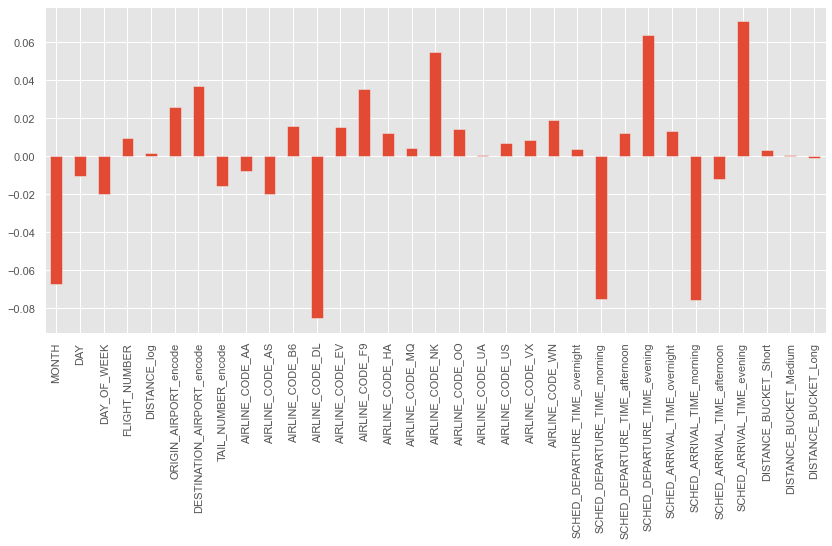

In [67]:
# Now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(14,6))

weights_sub = pd.Series(log_sgd_sub.coef_[0],index=df_weights_2.columns)
weights_sub.plot(kind='bar')
plt.show()

After removing `TAXI_IN_Log`, `DEPARTURE_DELAY_log`, `TAXI_OUT`, and `DIVERTED`, we start to see some other variable show higher importance, but it's still on the same scale as before we removed these four variables. We will revisit these in section 3.

In [73]:
# Re-run the best performing logistic regression model using standard test/train split
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)

log_final = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

for train_idx, test_idx in cv_object.split(X,y):
    log_final.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_final.predict(scl.transform(X[test_idx]))
    
    conf_final = mt.confusion_matrix(y[test_idx],yhat)
    acc_final = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc_final)
print('Confusion Matrix:\n', conf_final)

Logistic Regression: 0.8458027775492233
Confusion Matrix:
 [[695101  30375]
 [145787 271183]]


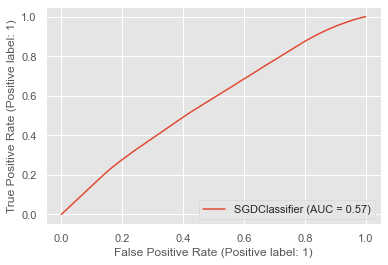

In [74]:
# Plot ROC curve
from sklearn.metrics import plot_roc_curve

mt.plot_roc_curve(log_final, X_test, y_test)  
plt.show()    

The ROC cuve doesn't line up with the false positive/false negative numbers we're seeing. This may be due to the test data split vs. the one in the iterations above. We will have to revisit this during next lab due to time constraints.

Our final best logistic regression model was created using:

- stochastic gradient descent
- `alpha`=0.1
- `penalty='l2'`
- `learning_rate='optimal'`
- 10-fold cross validation. 

This gave us an overall accuracy of 84.6%, a false positive rate of 17.3% and a false negative rate of 10.0%. 

### 1.14 SVM

#### 1.14.1 'Out-of-the-Box' SVM

In [75]:
from sklearn.model_selection import ShuffleSplit

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    X = df_final.iloc[:,:-1].values # use everything else to predict!

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)


In [76]:
# use some compact notation for creating a linear SVM classifier with stochastic descent
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM Accuracy:', acc)
print(conf)

SVM Accuracy: 0.8399224120877485
[[676675  48187]
 [134693 282891]]


Our "out-of-the-box" accuracy score here is 84% which is pretty good. However, since SVM takes so long to run on the full data set, we sampled 1% of our records in the data set  for the remaining models.

#### 1.14.2 Using Code From 04. Logits and SVM

In [77]:
# Sample our data to model off a smaller data set
df_svm_sample = df_final.sample(frac = 0.01, replace = False, random_state = 42)

In [78]:
# We want to predict the X and y data as follows:
if 'DELAYED' in df_svm_sample:
    y = df_svm_sample['DELAYED'].values # get the labels we want
    del df_svm_sample['DELAYED'] # get rid of the class label
    # X = df_svm_sample.values # use everything else to predict!
    X = df_svm_sample.iloc[:,:-1].values # since the above X removes Delayed
    
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

StandardScaler()

In [80]:
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [81]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set preditions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.860656455142232
[[6774  458]
 [1134 3059]]


This model returns an accuracy score of 86% which is a sight imporovement over our previous SVM model, but it is run on a fraction of the total records. If we decided to proceed using this model we may want to run it on the entire data set, or at least a larger sample size.

In [82]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(16652, 36)
(16652,)
[8440 8212]


#### 1.14.3 SVM with Linear Kernel

Code below is adapted from `04. Logits and SVM.ipynb`. We'll run this model using a linear kernal so as to be able visualize the weights.

In [83]:
# Let's investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# Train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set preditions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8533916849015317
[[6698  534]
 [1141 3052]]


In [84]:
# Look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(15882, 36)
(15882,)
[7947 7935]


In [85]:
print(svm_clf.coef_)

[[-4.28394401e-02 -7.87201243e-03 -3.06894344e-03 -5.15597728e-03
   7.84102197e-01  0.00000000e+00  1.41749666e+00 -1.16575077e-01
   3.60735217e-01  1.08321594e-02 -2.25759663e-04 -1.70447392e-02
  -6.12560506e-02  6.43412561e-02  4.13411141e-03 -1.13308949e-01
   2.98960392e-02  2.99288144e-02  9.19468433e-02 -6.29768119e-03
   5.69790053e-02  1.02328504e-02 -1.64852708e-01 -1.40585463e-02
   2.47144537e-02  1.51705587e-01  5.18523396e-03 -1.91836971e-02
   6.58696845e-03  1.22770220e-02 -1.31183083e-02  5.60342577e-03
   1.09151524e-02 -1.15026943e-02 -3.92037499e-03  5.92196175e-02]]


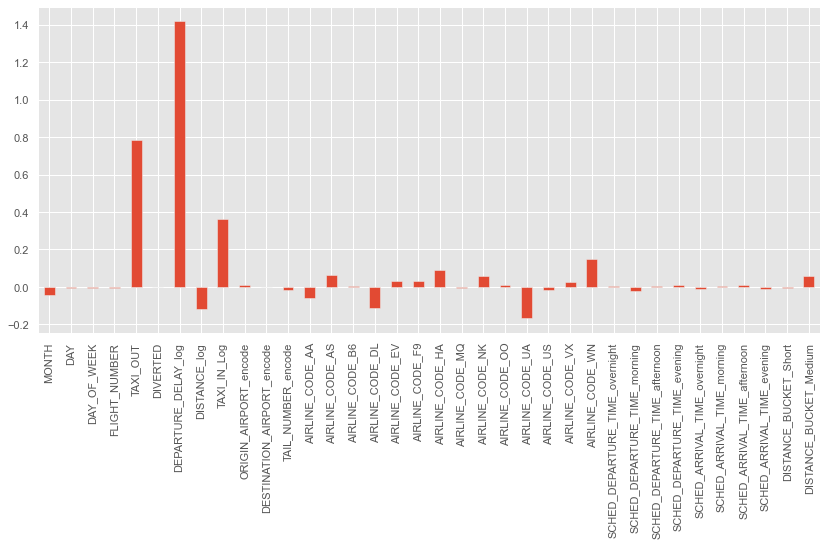

In [86]:
plt.figure(figsize=(14,6))

svm_weights = pd.Series(svm_clf.coef_[0],index=df_svm_sample.iloc[:,0:36].columns)
svm_weights.plot(kind='bar')
plt.show()

In [87]:
svm_clf.support_vectors_

array([[ 1.02216406, -1.21403859, -1.48477526, ...,  1.0846962 ,
        -0.10780651,  0.64599754],
       [-1.63371504, -1.44190207,  1.03117988, ..., -0.92191712,
        -0.10780651,  0.64599754],
       [-1.33861736,  1.06459621, -0.4783932 , ...,  1.0846962 ,
        -0.10780651, -1.54799351],
       ...,
       [-0.74842201, -0.98617511, -0.98158423, ...,  1.0846962 ,
        -0.10780651,  0.64599754],
       [-0.45332433,  0.03921055,  1.03117988, ..., -0.92191712,
        -0.10780651, -1.54799351],
       [ 0.4319687 ,  1.29245968,  0.02479782, ...,  1.0846962 ,
        -0.10780651,  0.64599754]])

In [88]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
# df_tested_on = df_svm_sample.iloc[train_indices].copy() # saved from above, the indices chosen for training
df_tested_on = df_svm_sample.iloc[:,:-1].copy() # saved from above, the indices chosen for training

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['DELAYED'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_svm_sample['DELAYED'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15882 entries, 5029127 to 1216372
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONTH                           15882 non-null  int64  
 1   DAY                             15882 non-null  int64  
 2   DAY_OF_WEEK                     15882 non-null  int64  
 3   FLIGHT_NUMBER                   15882 non-null  int64  
 4   TAXI_OUT                        15882 non-null  float64
 5   DIVERTED                        15882 non-null  int64  
 6   DEPARTURE_DELAY_log             15882 non-null  float64
 7   DISTANCE_log                    15882 non-null  float64
 8   TAXI_IN_Log                     15882 non-null  float64
 9   ORIGIN_AIRPORT_encode           15882 non-null  int64  
 10  DESTINATION_AIRPORT_encode      15882 non-null  float64
 11  TAIL_NUMBER_encode              15882 non-null  int64  
 12  AIRLINE_CODE_AA         

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


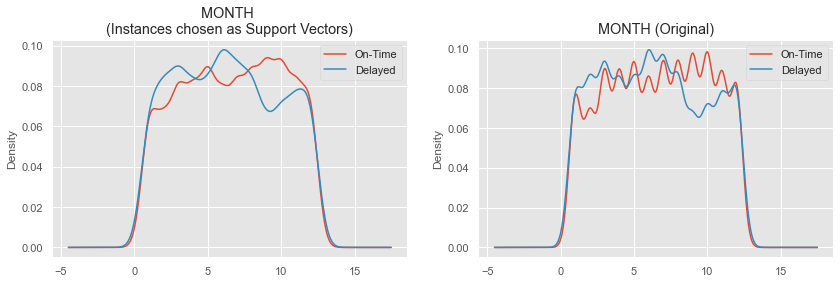

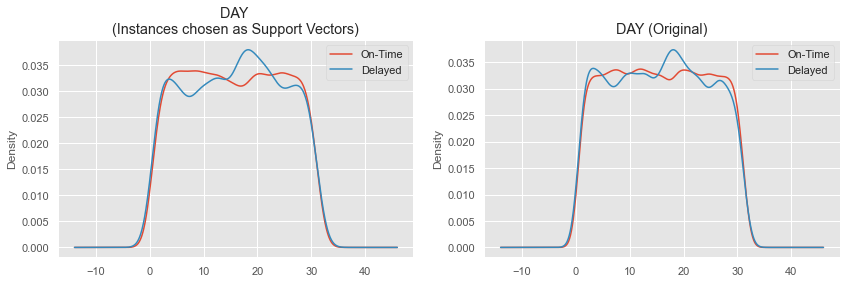

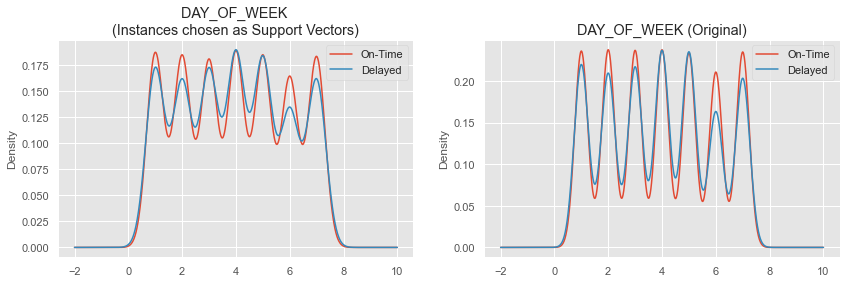

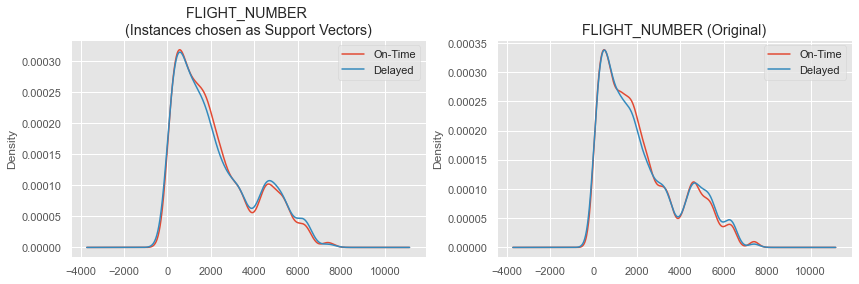

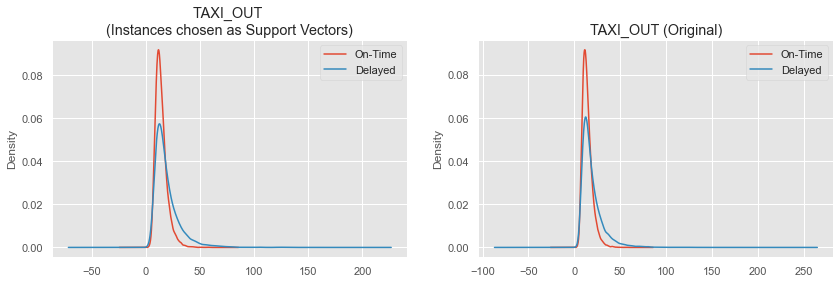

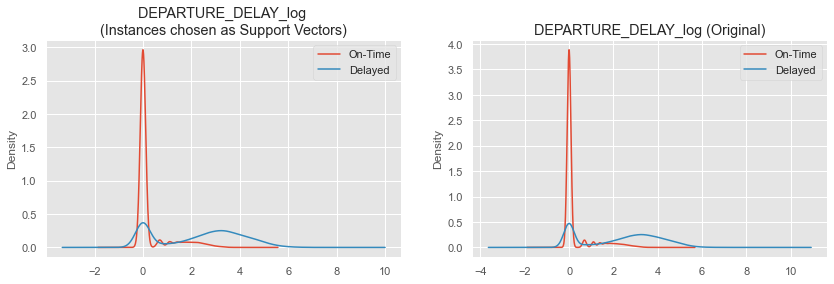

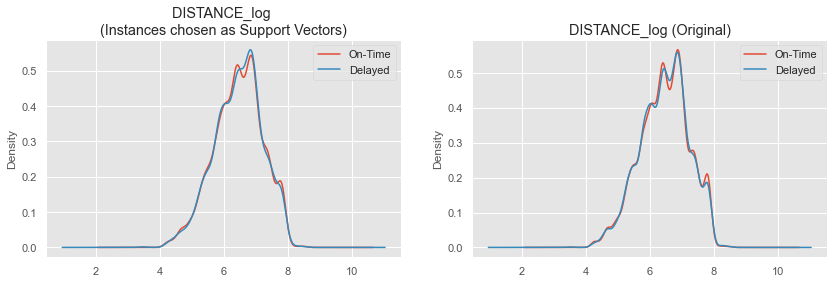

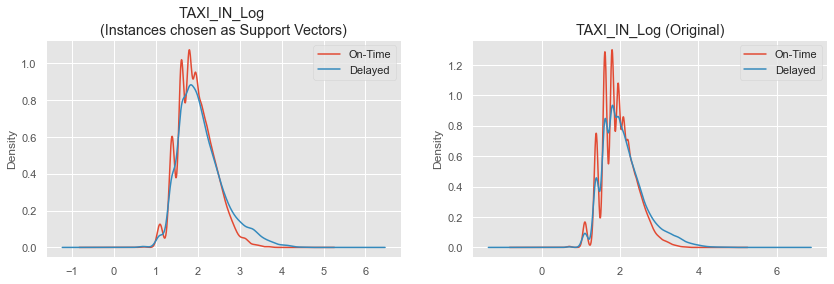

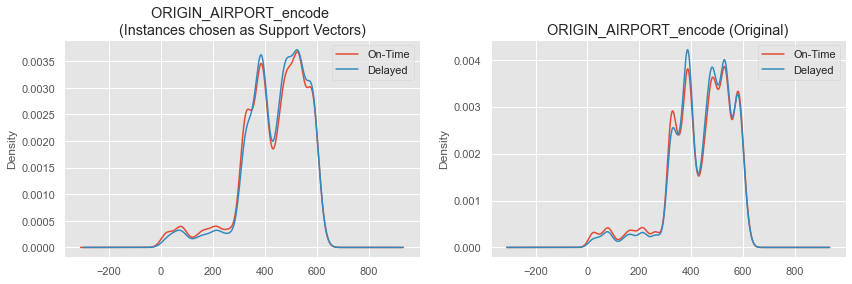

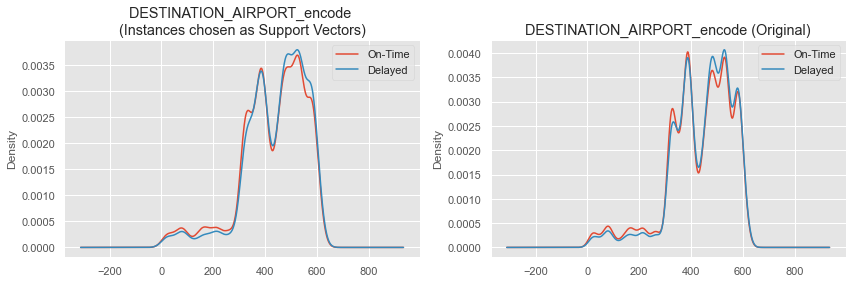

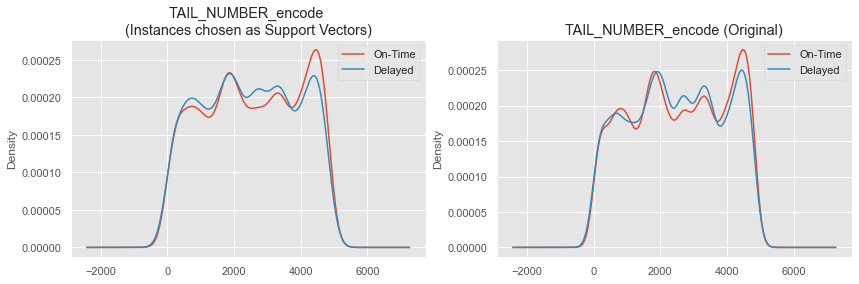

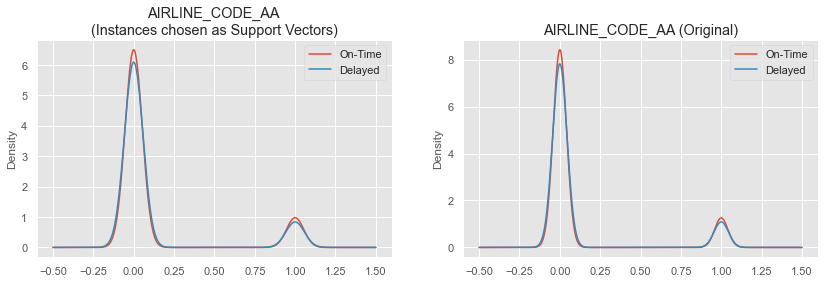

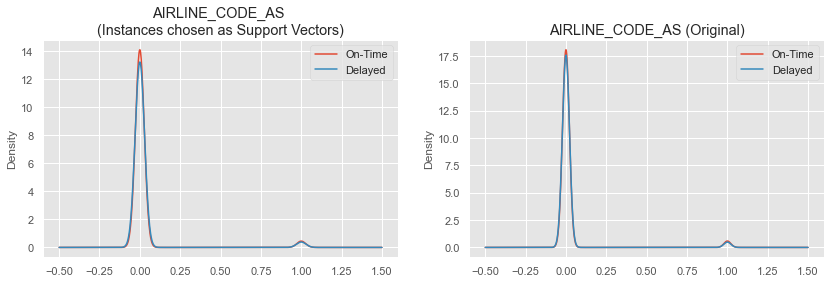

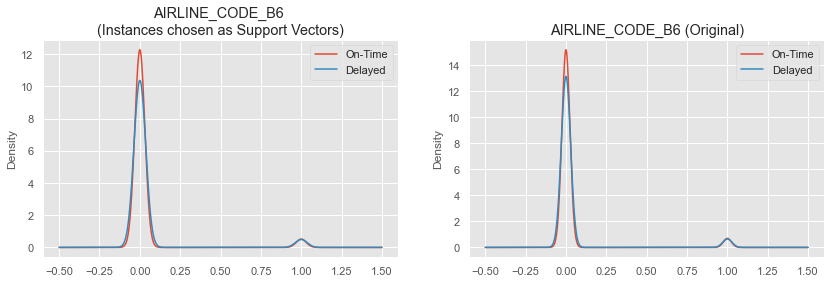

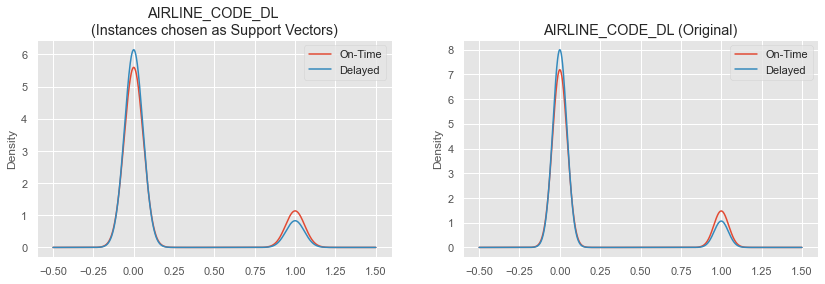

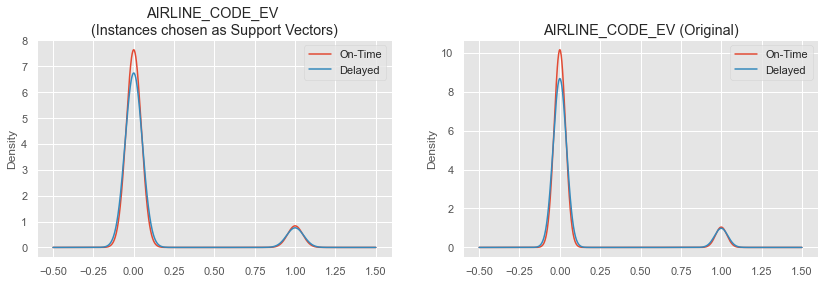

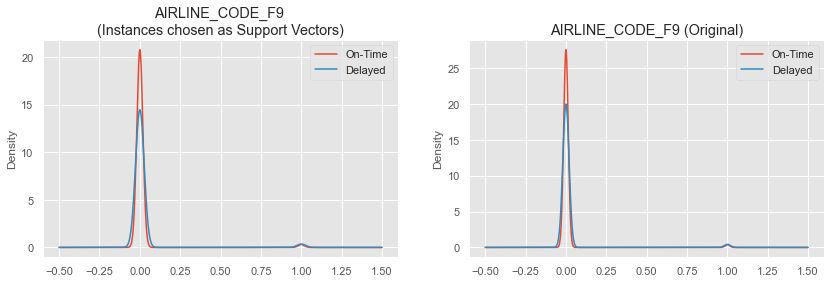

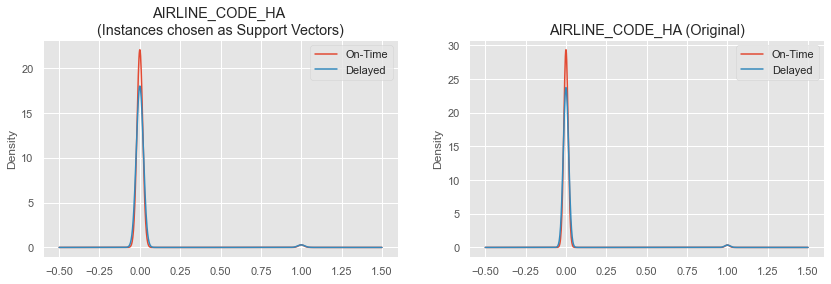

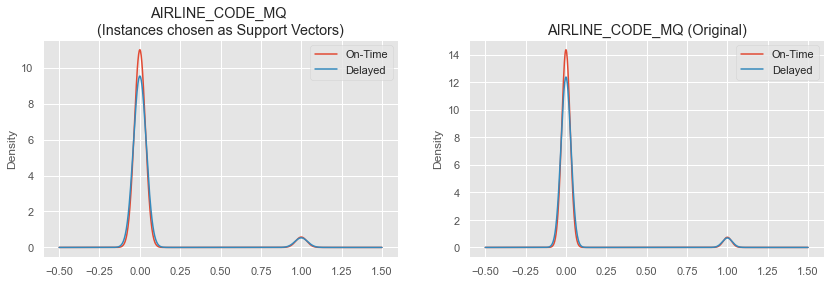

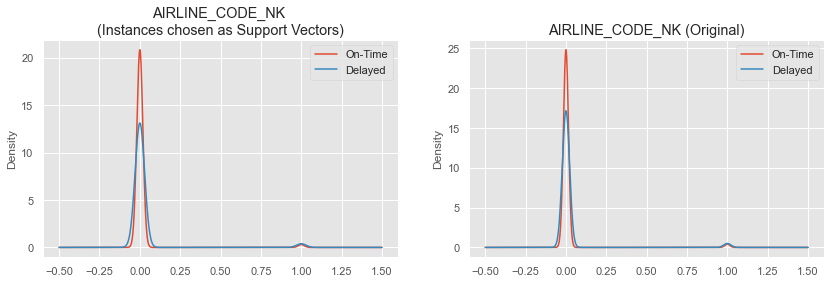

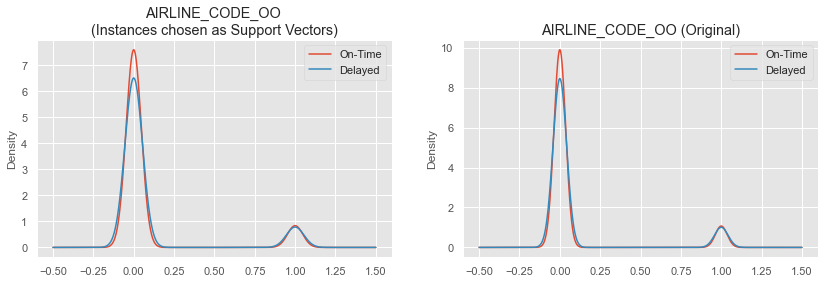

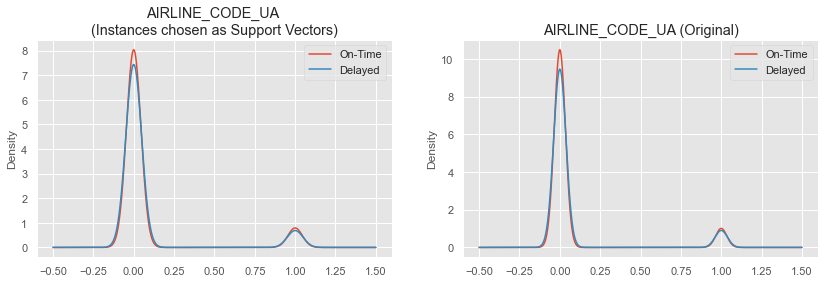

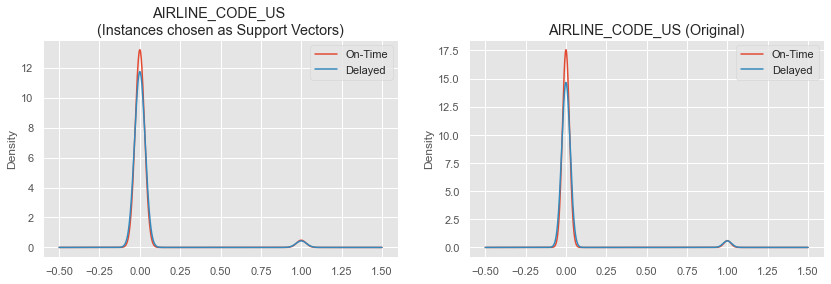

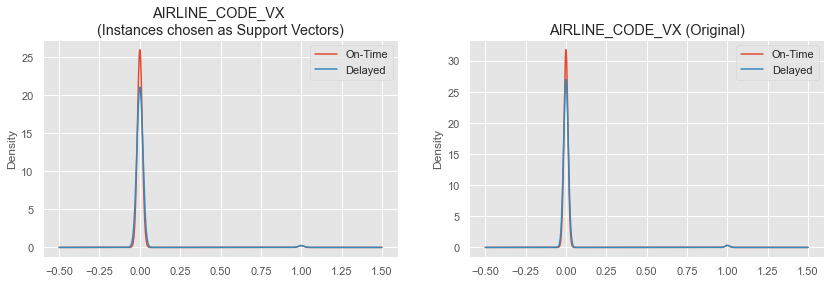

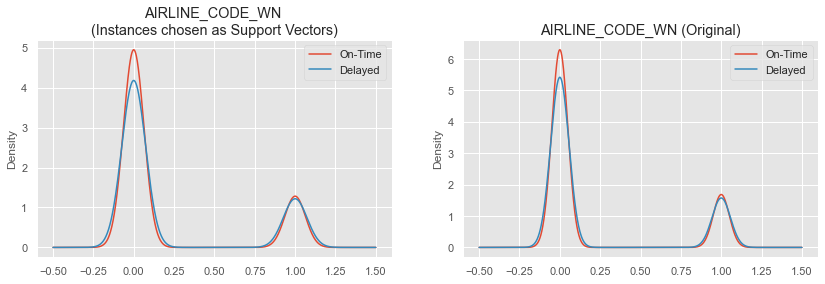

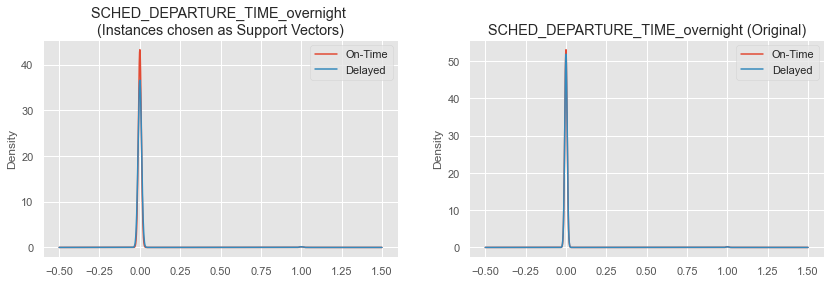

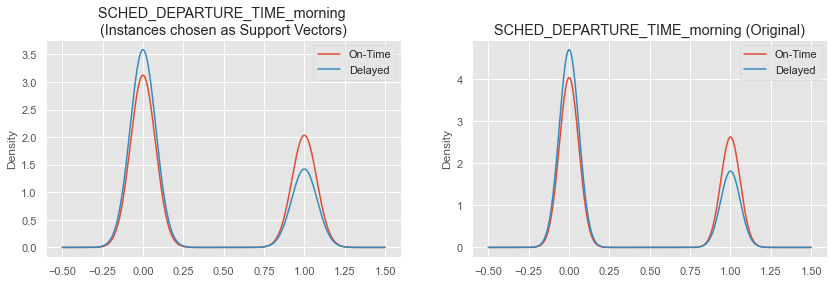

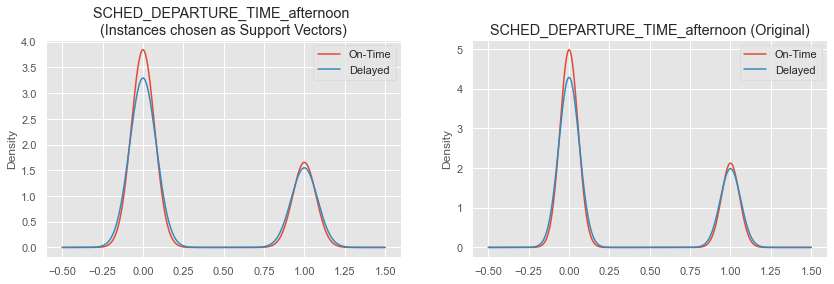

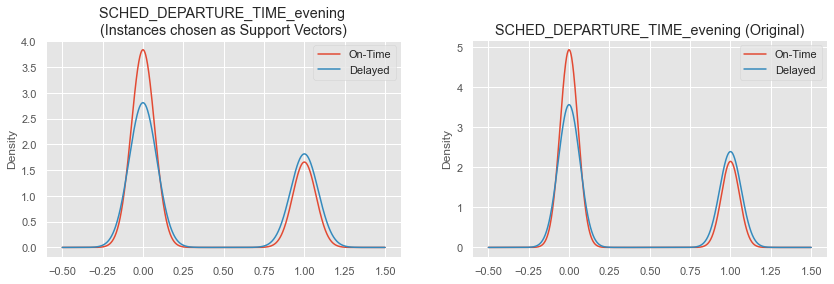

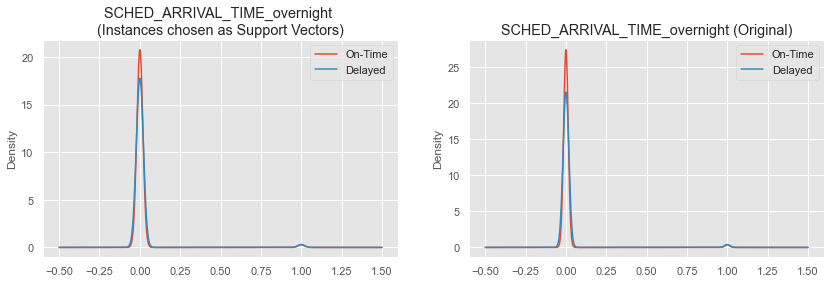

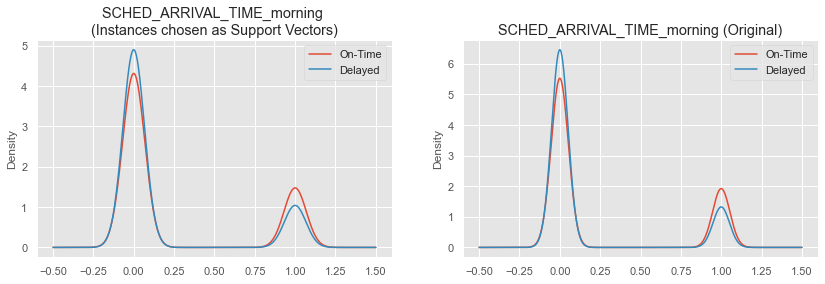

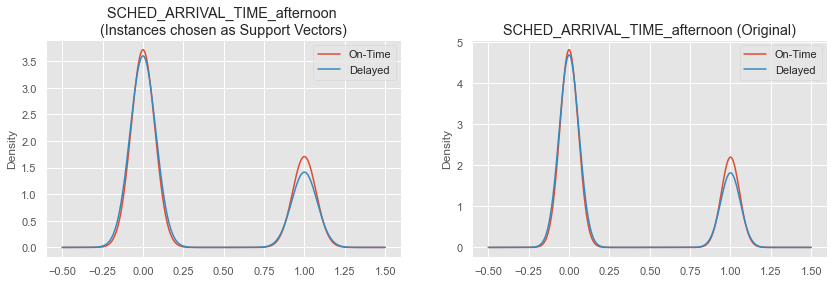

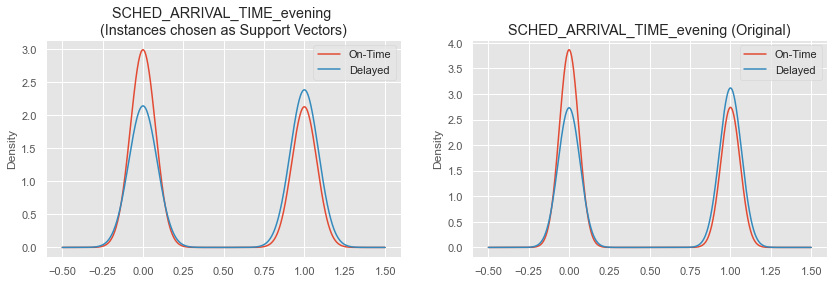

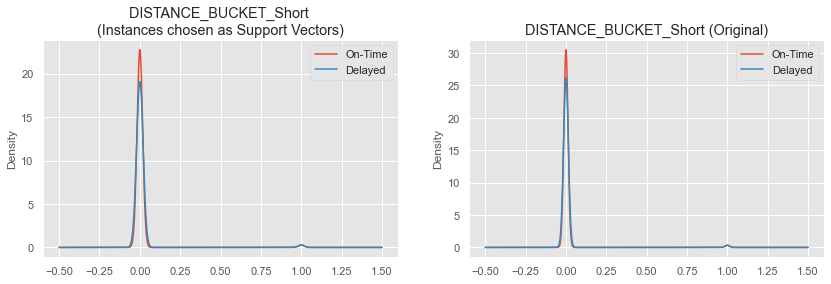

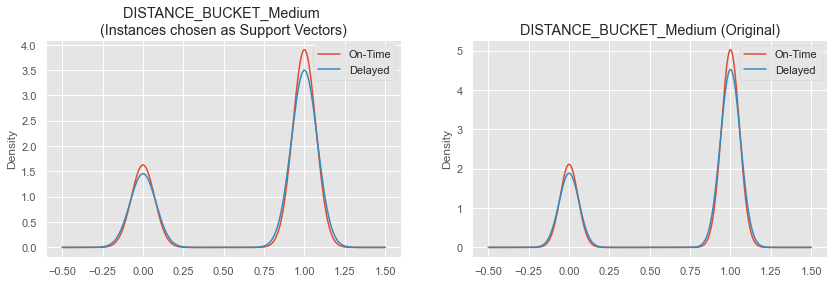

In [97]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['DELAYED'])
df_grouped = df_svm_sample.groupby(['DELAYED'])

# plot KDE of Different variables
vars_to_plot = ['MONTH',
                'DAY',
                'DAY_OF_WEEK',
                'FLIGHT_NUMBER',
                'TAXI_OUT',
                'DEPARTURE_DELAY_log',
                'DISTANCE_log',
                'TAXI_IN_Log',
                'ORIGIN_AIRPORT_encode',
                'DESTINATION_AIRPORT_encode',
                'TAIL_NUMBER_encode',
                'AIRLINE_CODE_AA',
                'AIRLINE_CODE_AS',
                'AIRLINE_CODE_B6' ,
                'AIRLINE_CODE_DL',
                'AIRLINE_CODE_EV',
                'AIRLINE_CODE_F9',
                'AIRLINE_CODE_HA',
                'AIRLINE_CODE_MQ',
                'AIRLINE_CODE_NK',
                'AIRLINE_CODE_OO',
                'AIRLINE_CODE_UA',
                'AIRLINE_CODE_US' , 
                'AIRLINE_CODE_VX',
                'AIRLINE_CODE_WN',
                'SCHED_DEPARTURE_TIME_overnight',
                'SCHED_DEPARTURE_TIME_morning',
                'SCHED_DEPARTURE_TIME_afternoon',
                'SCHED_DEPARTURE_TIME_evening',
                'SCHED_ARRIVAL_TIME_overnight',
                'SCHED_ARRIVAL_TIME_morning',
                'SCHED_ARRIVAL_TIME_afternoon',
                'SCHED_ARRIVAL_TIME_evening',
                'DISTANCE_BUCKET_Short',
                'DISTANCE_BUCKET_Medium'
               ]

for v in vars_to_plot:
    plt.figure(figsize=(14,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['On-Time','Delayed'])
    plt.title(v+' \n(Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['On-Time','Delayed'])
    plt.title(v+' (Original)')


After adapting to the linear model our accuracy fell 0.7% (from 86.0% to 85.3%) and the support vectors utilized reduced to 15,882 records from the 16,652 records of the sample set. This was a reduction of 770 total records using the Linear Kernel. Using the Linear model we utilized this data to visualize the feature comparison for on-time and delayed to see how SVM compares to the original data set, we discuss this further in the last section 4.

## 2. Advantages of Each Model

> **[10 points]** Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Our analysis shows that logistic regression model offered marginally better model accuracy than SVM. This makes sense since our data is structured and has identifiable variables, which is better for logistic regression. The logistic regression accuracy hovers around 85% across multiple iterations, whereas the SVM accuracy was 83.99%. 

SVM also utilized more computational resources than logistic regression and took significantly longer to process on our very large data set. We found grid search as part of feature selection to be both time consuming to process for both models, and was not able to be completed with our current computing resources.

Given the size of this data set, logistic regression offers more efficient and less time consuming model while also giving us interpretability and similar accuracy.

## 3. Feature Importance

> **[30 points]** Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### 3.1 Weight Comparisons

In this section we will plot our two variables weights from logistic regression for the data set that included all of our originally chosen features, then a subset of those features after removing the most influential ones (`TAXI_OUT`, `DEPARTURE_DELAY_log`, and `DISTANCE_Log`).

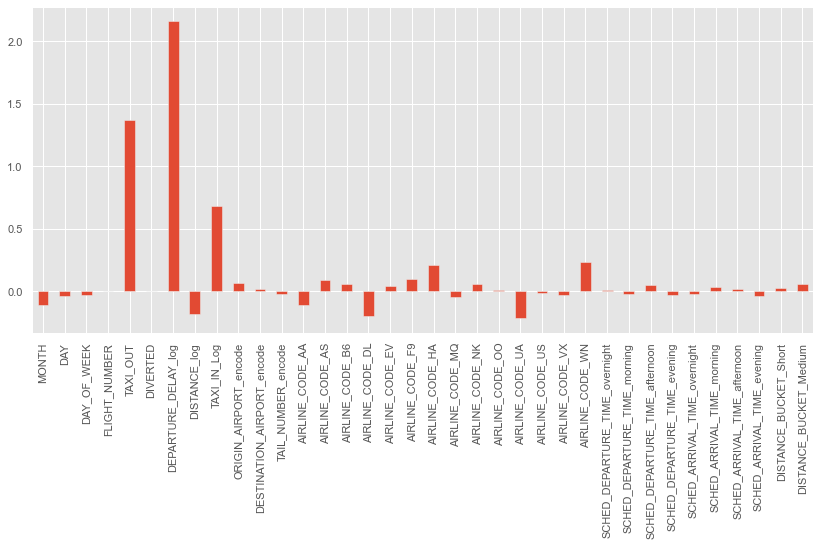

In [102]:
# Plot our variable weights again for all features
plt.figure(figsize=(14,6))

df_weights = df_final.iloc[:,:-1]
weights = pd.Series(log_final.coef_[0],index=df_weights.iloc[:,0:36].columns)
weights.plot(kind='bar')
plt.show()

In [103]:
#list weights
weights = log_final.coef_.T # take transpose to make a column vector
variable_names = df_final.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.11377899328605408
DAY has weight of -0.04006191505221114
DAY_OF_WEEK has weight of -0.029519092366859716
FLIGHT_NUMBER has weight of -0.0014396946649000246
TAXI_OUT has weight of 1.3674304012720668
DIVERTED has weight of 0.0
DEPARTURE_DELAY_log has weight of 2.1576648387802018
DISTANCE_log has weight of -0.17944403053687083
TAXI_IN_Log has weight of 0.6832055455523375
ORIGIN_AIRPORT_encode has weight of 0.06916693444810978
DESTINATION_AIRPORT_encode has weight of 0.014106009359601043
TAIL_NUMBER_encode has weight of -0.020230358034010104
AIRLINE_CODE_AA has weight of -0.10838268931856632
AIRLINE_CODE_AS has weight of 0.08626723581275002
AIRLINE_CODE_B6 has weight of 0.054816808640466196
AIRLINE_CODE_DL has weight of -0.19835313187403078
AIRLINE_CODE_EV has weight of 0.04454394090644653
AIRLINE_CODE_F9 has weight of 0.09514281612679475
AIRLINE_CODE_HA has weight of 0.21172608726511472
AIRLINE_CODE_MQ has weight of -0.045426918945957184
AIRLINE_CODE_NK has weight o

Our final chosen feature set gave good accuracy at 84.6% for logistic regression, but several variables had a relatively low variable weight incomparison to our top four.

Top three coefficients (with a value > 1) and their value:
- `TAXI_OUT` at 1.367 - For every one unit increase in time for TAXI_OUT, the odds of the flight being delayed will increase by a multiplicative factor of 3.92, holding all else fixed.
- `DEPARTURE_DELAY_log` at 2.158 - For every one unit increase in the log of the departure delay, the odds of the flight being delayed will increase by a multiplicative factor of 8.65, holding all else fixed.
- `TAXI_IN_Log` at 0.683 - For every one unit increase in the log of TAXI_IN time, the odds of the flight being delayed will increase by a multiplicative factor of 1.98, holding all else fixed.

These three features are all continuous variables that indicate the time for taxiing out in minutes, the log of the departure delay time in minutes, and the log of the taxi in time in minutes. Surprisingly, these variables did not show a strong (above 0.8) correlation to any other variable or do our desired response variable `DELAYED`. However, thinking practically, it would make sense for our model to choose these as the longer both the taxi in and taxi out time, the (generally) longer the arrival delay will be. Also, even though a late departure does not always guarantee a late arrival (as pilots can make up time in the air), our model puts a high weight on this variable based on our data set. This indicates that this feature is a good predictor of `ARRIVAL_DELAY` and hence our binary response variable `DELAYED`.

In comparison, we also looked at the coefficient weights after removing these top three as well as `DIVERTED`, which had a weight of `0`.

In [104]:
# Iterate over the coefficients and interpret the weights
weights_sub = log_sgd_sub.coef_.T # take transpose to make a column vector
variable_names = df_final[vars_SUB]
for coef, name in zip(weights_sub,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.06739066957110228
DAY has weight of -0.010359954435967296
DAY_OF_WEEK has weight of -0.01970793995808001
FLIGHT_NUMBER has weight of 0.009751378490926268
DISTANCE_log has weight of 0.0016578105552243103
ORIGIN_AIRPORT_encode has weight of 0.025615302165053647
DESTINATION_AIRPORT_encode has weight of 0.03670215343210099
TAIL_NUMBER_encode has weight of -0.015436826332782762
AIRLINE_CODE_AA has weight of -0.007893472329668545
AIRLINE_CODE_AS has weight of -0.02011293789837286
AIRLINE_CODE_B6 has weight of 0.015660976865291533
AIRLINE_CODE_DL has weight of -0.08503494928396253
AIRLINE_CODE_EV has weight of 0.01521991750887366
AIRLINE_CODE_F9 has weight of 0.035522756296004786
AIRLINE_CODE_HA has weight of 0.012329518945131993
AIRLINE_CODE_MQ has weight of 0.004492433869347768
AIRLINE_CODE_NK has weight of 0.054870353109447385
AIRLINE_CODE_OO has weight of 0.014289501515496815
AIRLINE_CODE_UA has weight of 0.0004942345423121598
AIRLINE_CODE_US has weight of 0.0066854

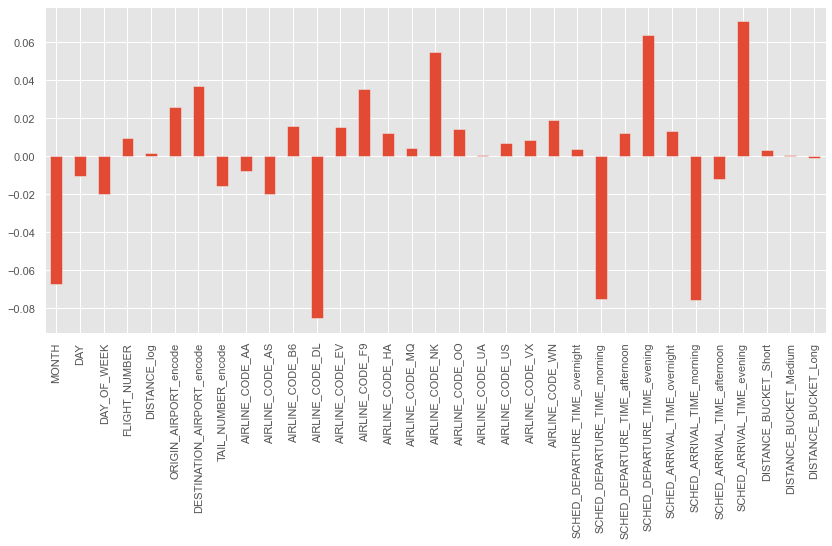

In [105]:
plt.figure(figsize=(14,6))

weights_sub = pd.Series(log_sgd_sub.coef_[0],index=df_weights_2.columns)
weights_sub.plot(kind='bar')
plt.show()

The above results are from a model with less accuracy at 63.5% with the most important variables removed. Once these were removed, we start to see some other variables that were more difficult to visualize as important when the scale was skewed for the higher-weighted ones. We see that `MONTH`, some specific airlines, and some specific departure or arrival buckets seem to influence the outcome more than others.

- `MONTH` has a coefficient value of -0.067 which indicates that for every one unit increase in month (going from January=1 to December=12), the odds of the flight being delayed decrease by 6.5% keeping all other items constant.
- `AIRLINE_CODE_DL` has a coefficient value of -0.085. This tells us that flying on Delta will likely be delayed less often than some of the other airlines in this data set.
- `SCHED_DEPARTURE_TIME_overnight` and `SCHED_ARRIVAL_TIME_morning` are both highly negative which also indicates that flights that leave very late at night and/or arrive early in the morning also tend to be delayed less often.

## 4. Support Vectors

> **[10 points]** Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.

In [106]:
# Look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(15882, 36)
(15882,)
[7947 7935]


/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


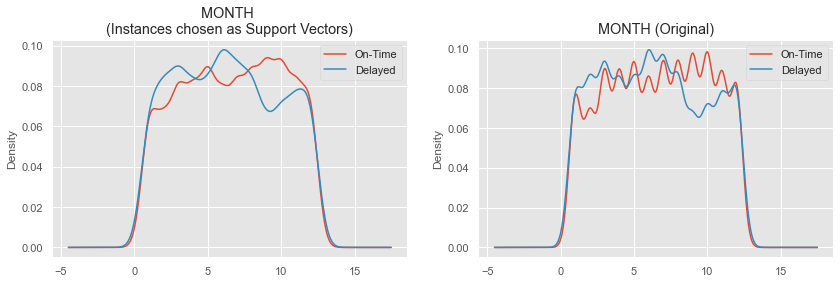

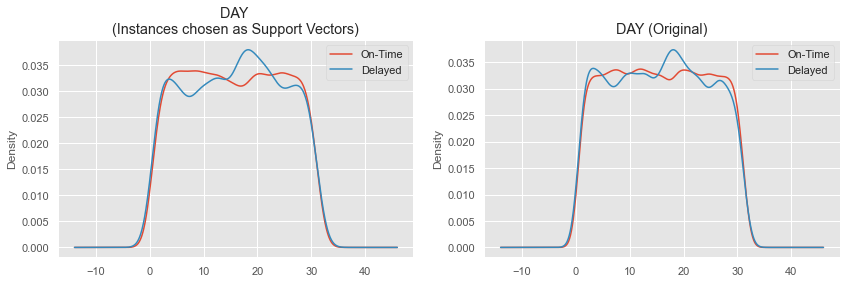

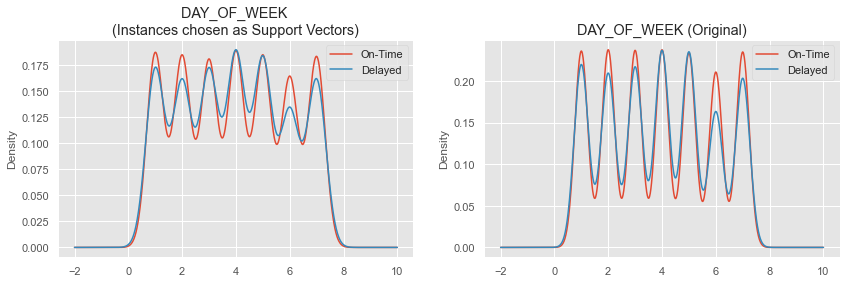

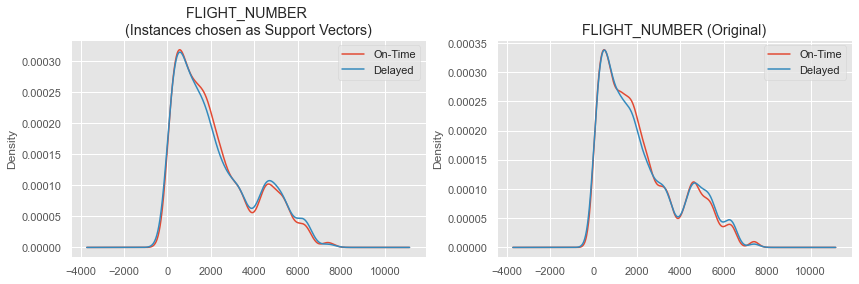

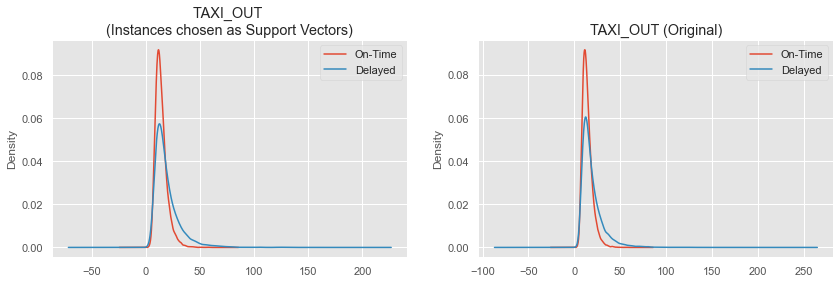

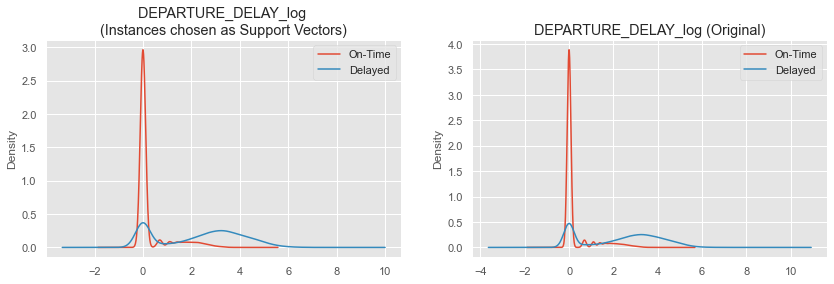

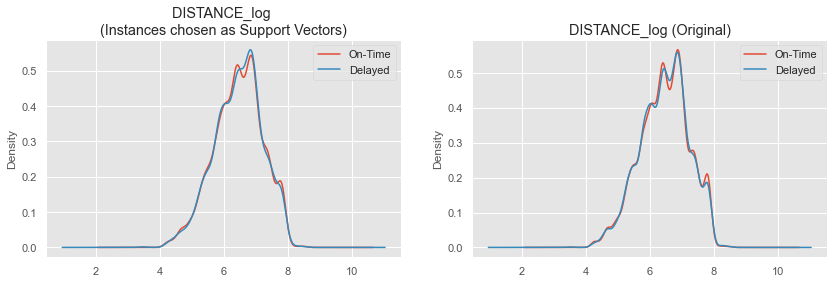

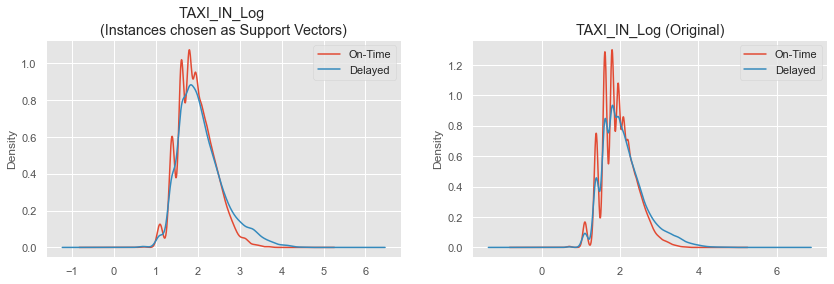

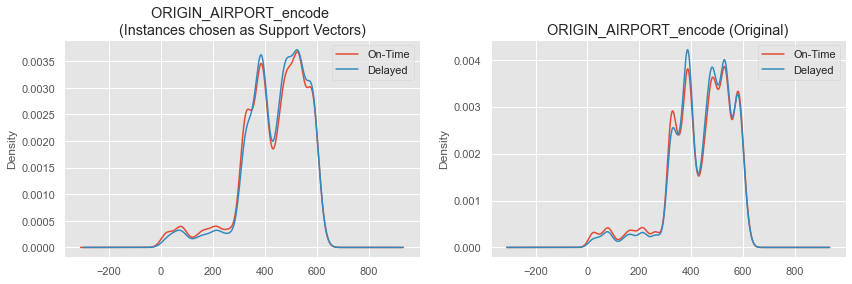

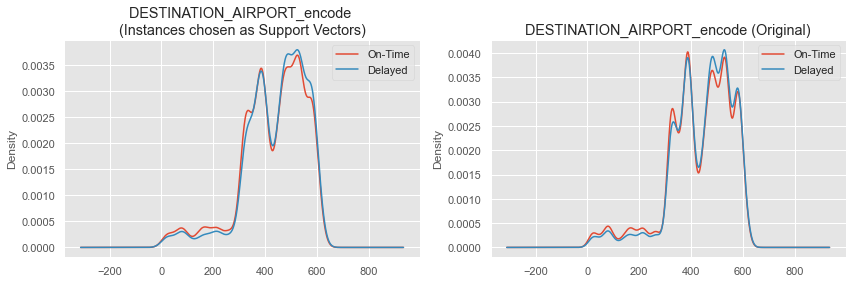

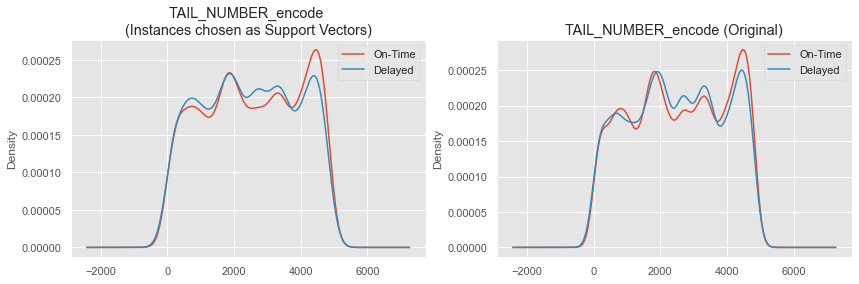

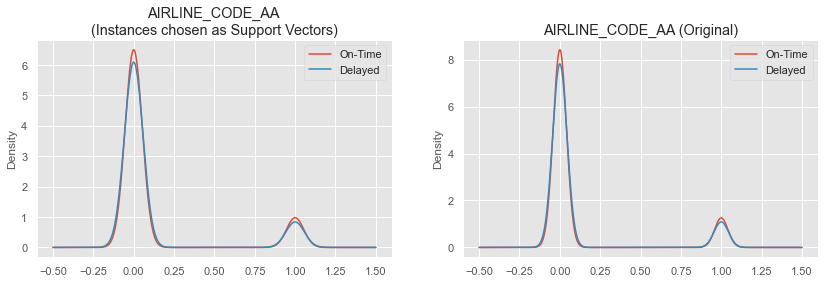

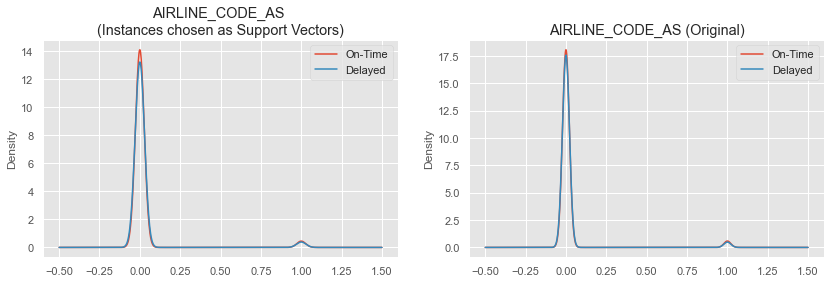

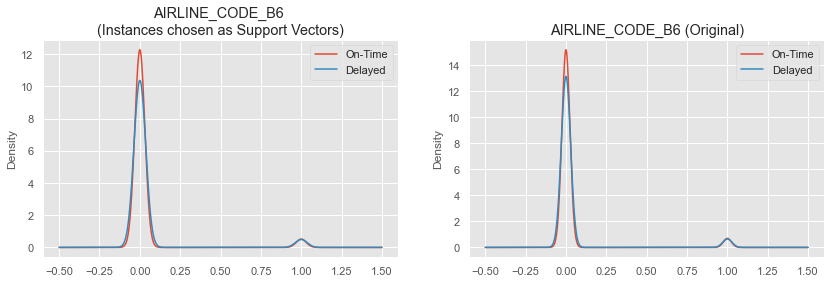

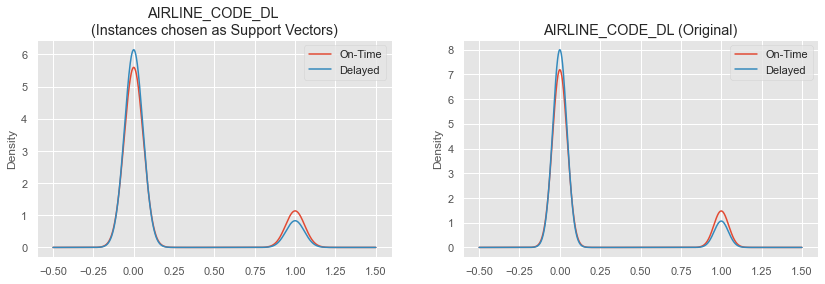

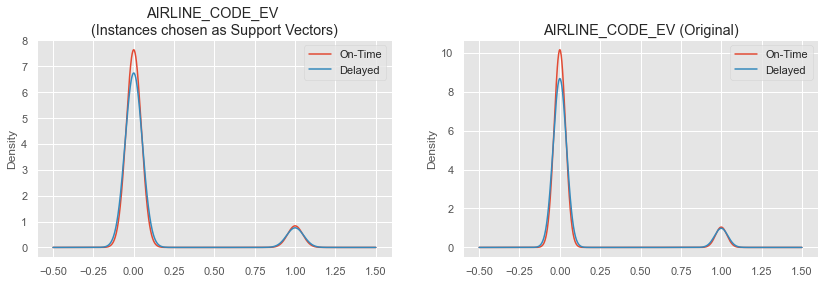

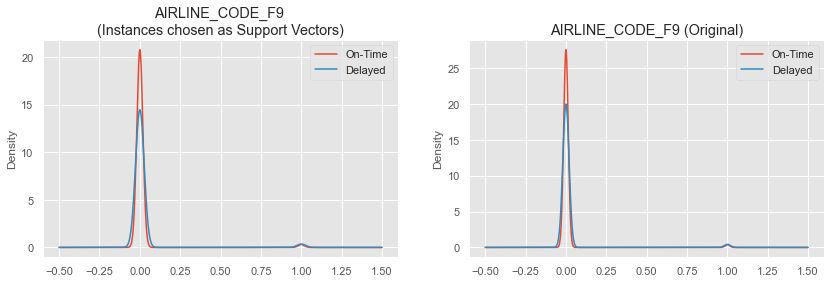

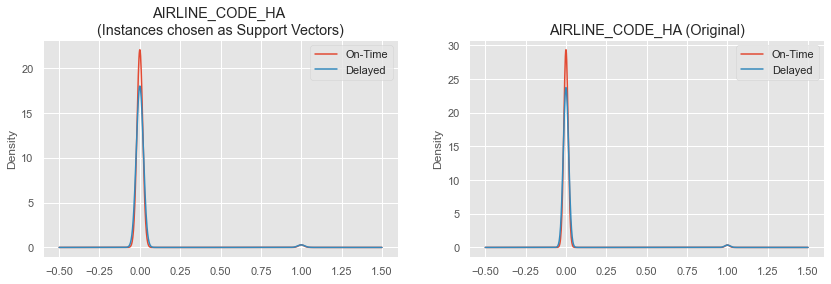

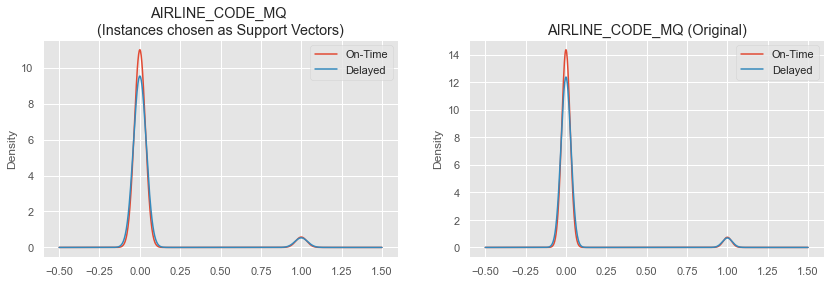

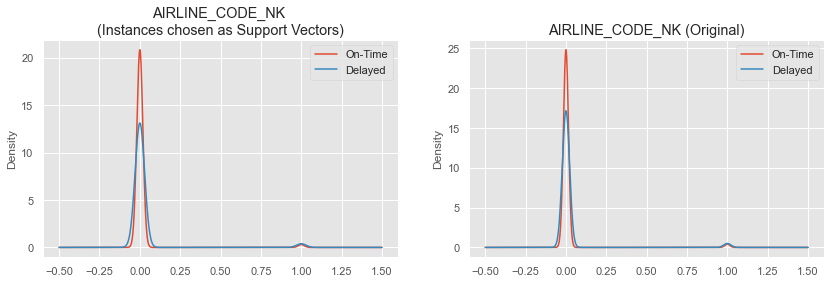

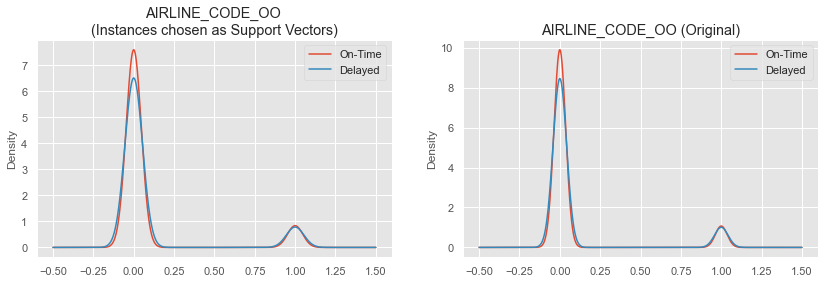

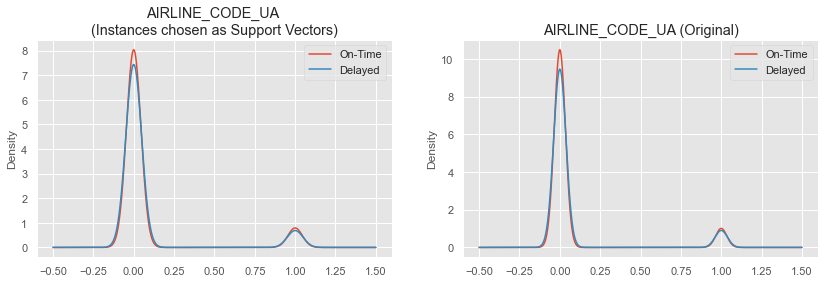

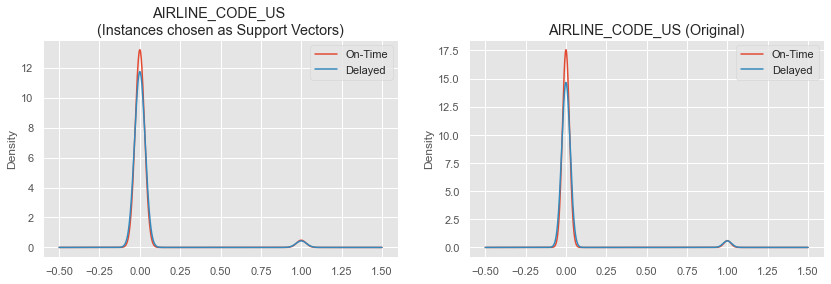

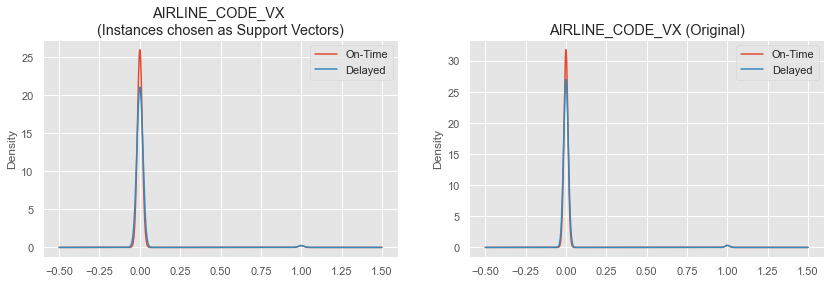

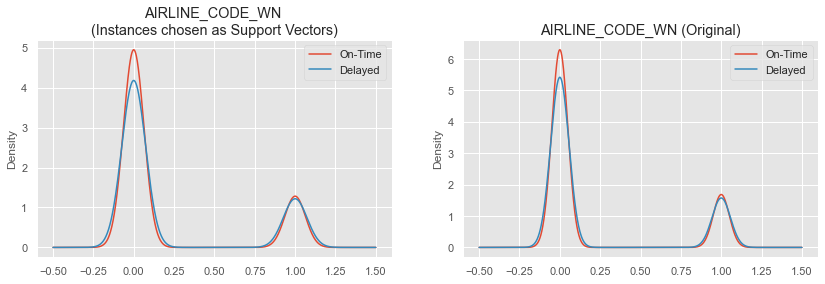

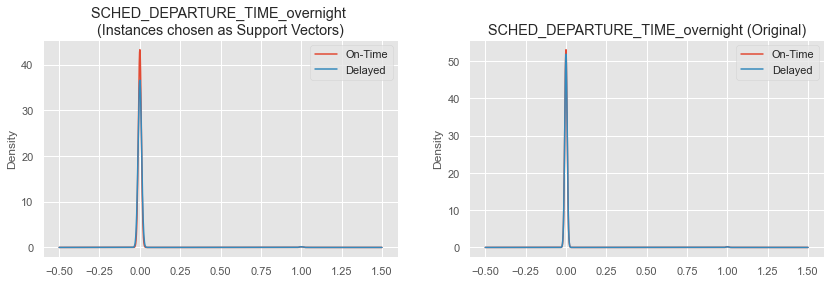

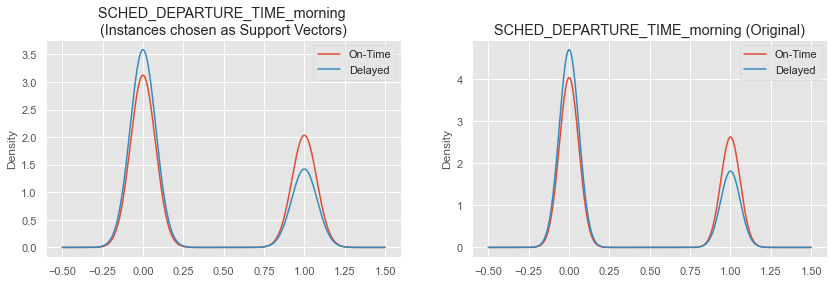

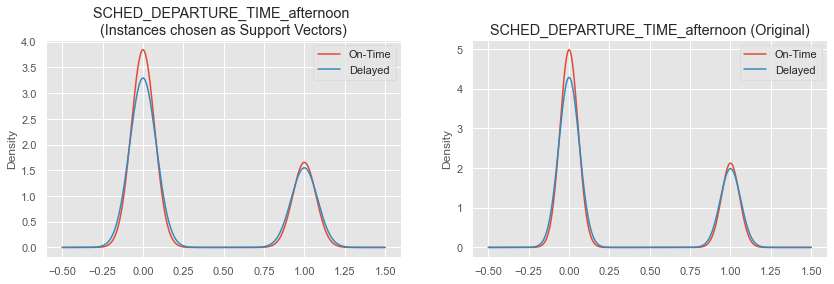

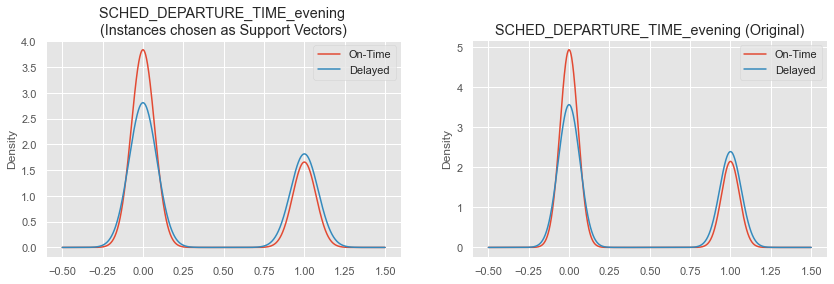

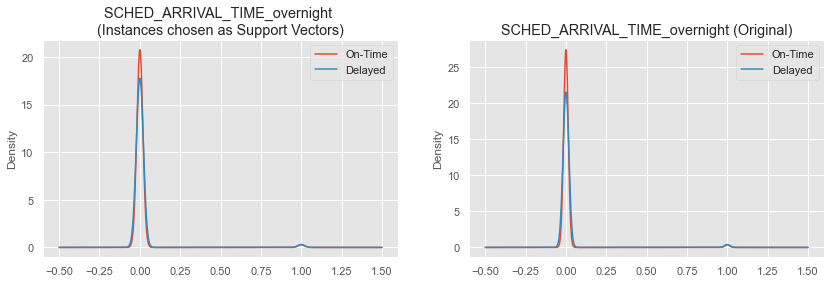

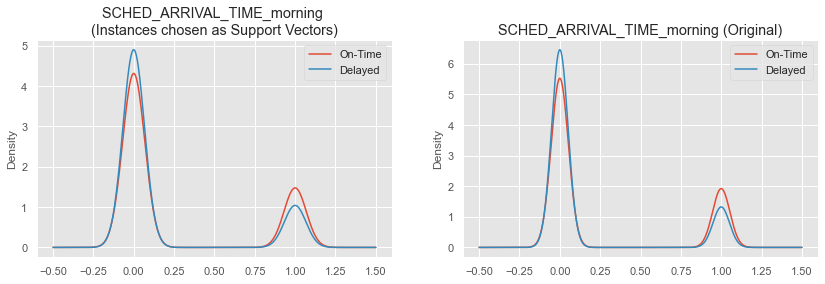

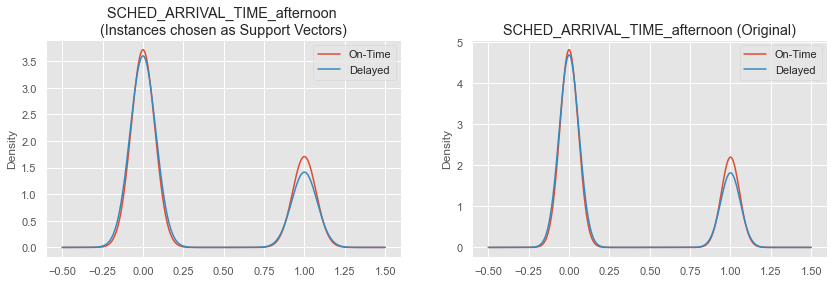

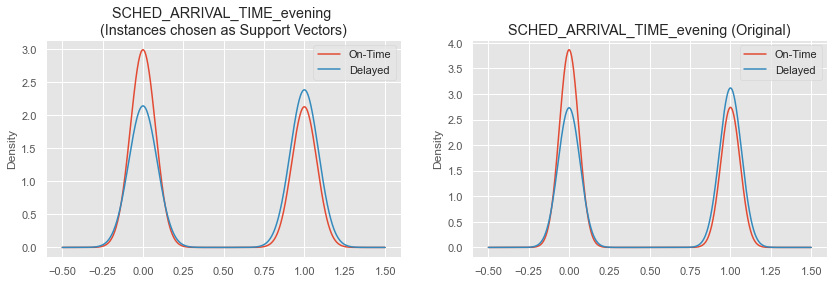

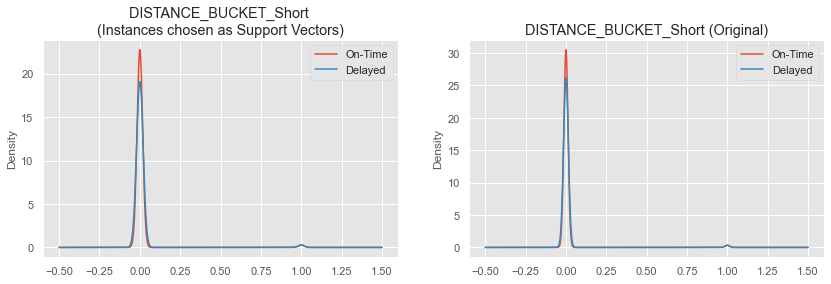

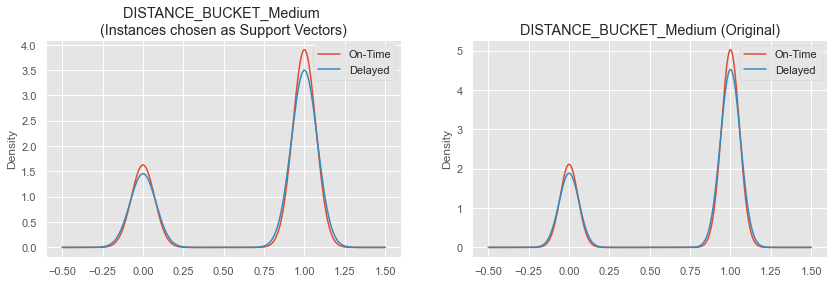

In [107]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['DELAYED'])
df_grouped = df_svm_sample.groupby(['DELAYED'])

# plot KDE of Different variables
vars_to_plot = ['MONTH',
                'DAY',
                'DAY_OF_WEEK',
                'FLIGHT_NUMBER',
                'TAXI_OUT',
                'DEPARTURE_DELAY_log',
                'DISTANCE_log',
                'TAXI_IN_Log',
                'ORIGIN_AIRPORT_encode',
                'DESTINATION_AIRPORT_encode',
                'TAIL_NUMBER_encode',
                'AIRLINE_CODE_AA',
                'AIRLINE_CODE_AS',
                'AIRLINE_CODE_B6' ,
                'AIRLINE_CODE_DL',
                'AIRLINE_CODE_EV',
                'AIRLINE_CODE_F9',
                'AIRLINE_CODE_HA',
                'AIRLINE_CODE_MQ',
                'AIRLINE_CODE_NK',
                'AIRLINE_CODE_OO',
                'AIRLINE_CODE_UA',
                'AIRLINE_CODE_US' , 
                'AIRLINE_CODE_VX',
                'AIRLINE_CODE_WN',
                'SCHED_DEPARTURE_TIME_overnight',
                'SCHED_DEPARTURE_TIME_morning',
                'SCHED_DEPARTURE_TIME_afternoon',
                'SCHED_DEPARTURE_TIME_evening',
                'SCHED_ARRIVAL_TIME_overnight',
                'SCHED_ARRIVAL_TIME_morning',
                'SCHED_ARRIVAL_TIME_afternoon',
                'SCHED_ARRIVAL_TIME_evening',
                'DISTANCE_BUCKET_Short',
                'DISTANCE_BUCKET_Medium'
               ]

for v in vars_to_plot:
    plt.figure(figsize=(14,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['On-Time','Delayed'])
    plt.title(v+' \n(Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['On-Time','Delayed'])
    plt.title(v+' (Original)')


We reviewed support vectors for `DELAYED` where **0** represents On-Time and **1** represents Delayed. The number of support vectors in this linear model was 15,823, out of the 1% sampled data which is a low subset of our original data (about 27%). Out of this subset of data, when reviewing Support vectors, `TAXI_OUT`, `DEPARTURE_DELAY_log`, and `TAXI_IN_Log` stood out as these features did not do well in preserving original data integrity.

`TAXI_OUT`

This variable had a similar shape, but did not represent the spike seen in the On-Time group of the original data. The original peak had a peak of 0.9 on the Y-axis while the SVM shows little to no variation.

`DEPARTURE_DELAY_log`

There is not a peak with the same intensity as in original data set. The overall shape is similar but does have some distinct areas in the X axis (starting at 2.5 and ending at 5.0 in the original data set) where it does not follow the same pattern.

`TAXI_IN_Log`

The shape in the SVM model did not fit the original data set; there should have been more of a difference between Delayed and On-Time as seen above. In the original data, `Delayed` does not marry up to `On-Time` as is shown in SVM. This clearly shows a clear discrepancy between the two.

For support vector models, this is not highly surprising since “support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.” ***– per DataMiningNotebook/Logits and SVM.ipynb.*** Overall, for the majority of the features, SVM did keep the integrity of the original data with these few key exceptions.

## 5. Final Thoughts

After beginning to fit logistic regression and diving further into feature selection, it became apparent that we may not have chosen the best response variable for this data set. Choosing `DELAYED` as our first response variable to classify meant we had to eliminate several redundant or correlated features which significantly reduced the variables that we could find important. This also hindered our ability to significantly change our accuracy even with changing parameters within the models. Moving forward, we will be re-assessing model building by choosing `CANCELLED` as our classification response variable and will have to manage the challenges that come with such an unbalanced variable.